## CartPole simple DQN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from collections import namedtuple
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    print('output movie...')
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=20)
    anim.save('movie_cartpole_dqn.mp4')
    display(display_animation(anim, default_mode='loop'))
    
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 1000

In [2]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0
        
    def push(self, state, action, state_next, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.index] = Transition(state, action, state_next, reward)
        self.index = (self.index + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [3]:
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000 # max len of replay memory

class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions
        self.memory = ReplayMemory(CAPACITY)
        
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))
        print(self.model)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        
    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        self.model.eval()
        state_action_values = self.model(state_batch).gather(1, action_batch)
        
        non_final_mask = torch.ByteTensor(
            tuple(map(lambda s: s is not None, batch.next_state)))
        next_state_values = torch.zeros(BATCH_SIZE)
        
        next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()
        
        expected_state_action_values = reward_batch + GAMMA * next_state_values
        
        self.model.train()
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def decide_action(self, state, episode):
        eps = 0.5 * (1 / (episode + 1))
        
        if eps <= np.random.uniform(0, 1):
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
        else:
            action = torch.LongTensor([[random.randrange(self.num_actions)]])
        
        return action
        
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
        
    def update_q_function(self):
        self.brain.replay()
        
    def get_action(self, state, episode):
        return self.brain.decide_action(state, episode)
    
    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)

In [4]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV)
        self.num_states = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n
        self.agent = Agent(self.num_states, self.num_actions)
        
    def run(self):
        episode_10_list = np.zeros(10)
        complete_episodes = 0
        episode_final = False
        frames = []
        
        for episode in range(NUM_EPISODES):
            observation = self.env.reset()
            
            state = observation
            state = torch.from_numpy(state).type(torch.FloatTensor)
            state = torch.unsqueeze(state, 0)
            
            for step in range(MAX_STEPS):
                if episode_final is True:
                    frames.append(self.env.render(mode='rgb_array'))
                
                action = self.agent.get_action(state, episode)
                observation_next, _, done, _ = self.env.step(action.item())
                
                if done:
                    state_next = None
                    episode_10_list = np.hstack((episode_10_list[1:], step + 1))
                    
                    if step < 195:
                        reward = torch.FloatTensor([-1.0])
                        complete_episodes = 0
                    else:
                        reward = torch.FloatTensor([1.0])
                        complete_episodes += 1
                else:
                    reward = torch.FloatTensor([0.0])
                    state_next = observation_next
                    state_next = torch.from_numpy(state_next).type(torch.FloatTensor)
                    state_next = torch.unsqueeze(state_next, 0)

                self.agent.memorize(state, action, state_next, reward)
                self.agent.update_q_function()
                state = state_next
                    
                if done:
                    if episode % 20 is 0:
                        print('%d Episode: Finished after %d steps : Average steps = %.1lf' % (episode, step + 1, episode_10_list.mean()))
                    break
                        
            if episode_final is True:
                display_frames_as_gif(frames)
                self.env.close()
                break

            if complete_episodes >= 10:
                print('succeeded 10 times successively')
                episode_final = True
                    

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 13 steps : Average steps = 1.3
20 Episode: Finished after 13 steps : Average steps = 11.0
40 Episode: Finished after 9 steps : Average steps = 10.2
60 Episode: Finished after 70 steps : Average steps = 63.0
80 Episode: Finished after 105 steps : Average steps = 82.8
100 Episode: Finished after 109 steps : Average steps = 107.8
120 Episode: Finished after 98 steps : Average steps = 108.2
140 Episode: Finished after 200 steps : Average steps = 120.6
160 Episode: Finished after 83 steps : Average steps = 82.3
180 Episode: Finished after 106 steps : Average steps = 92.9
200 Episode: Finished after 51 steps : Average steps = 85.5
220 Episode: F


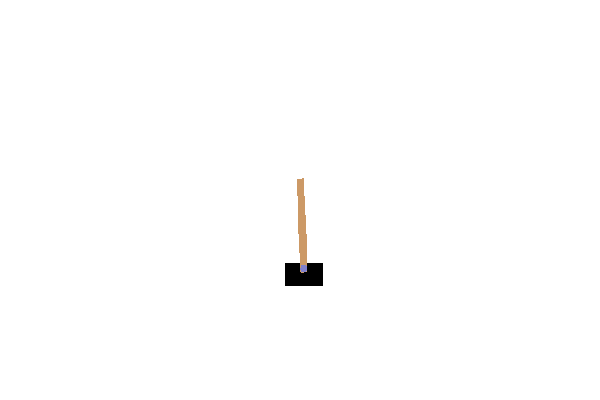
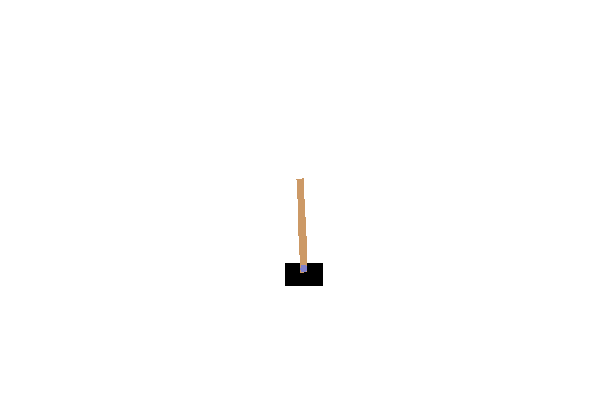
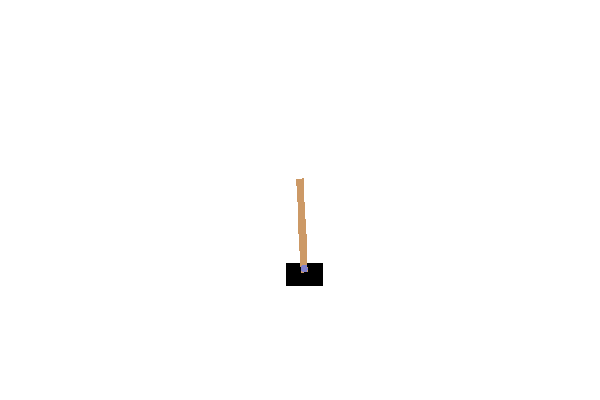
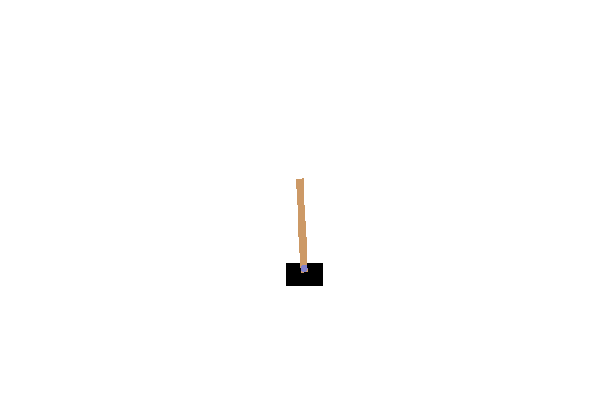
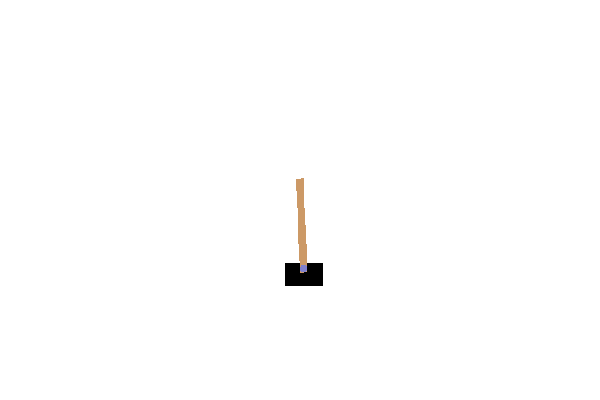
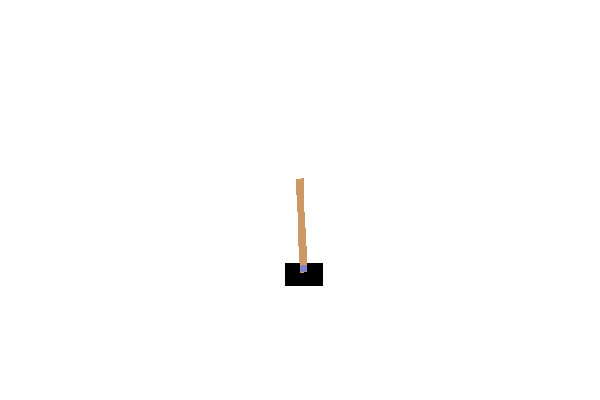
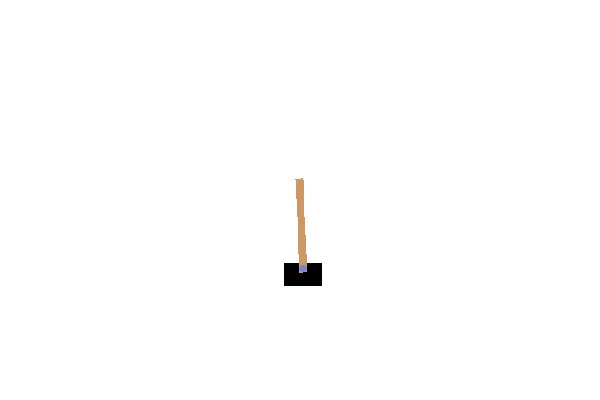
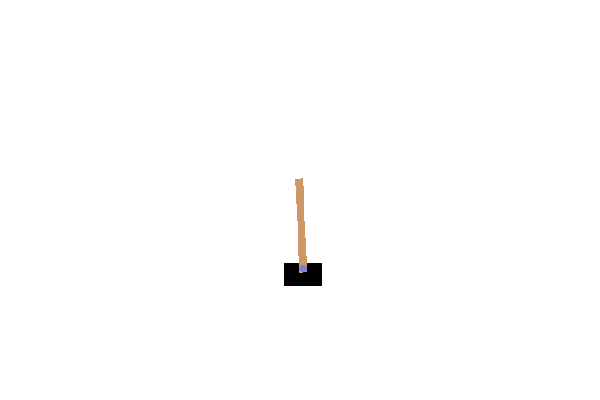
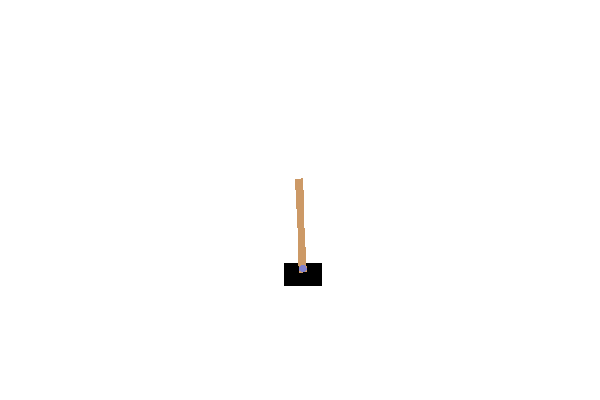
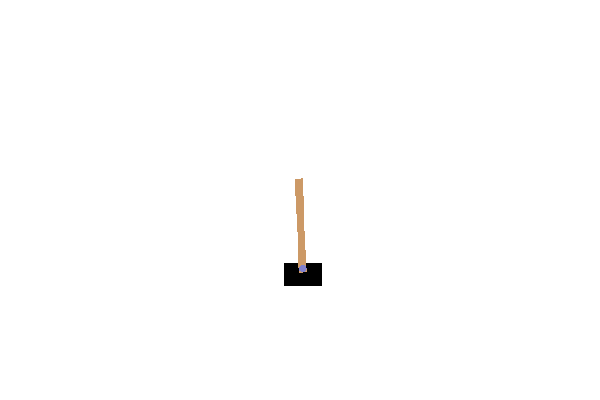
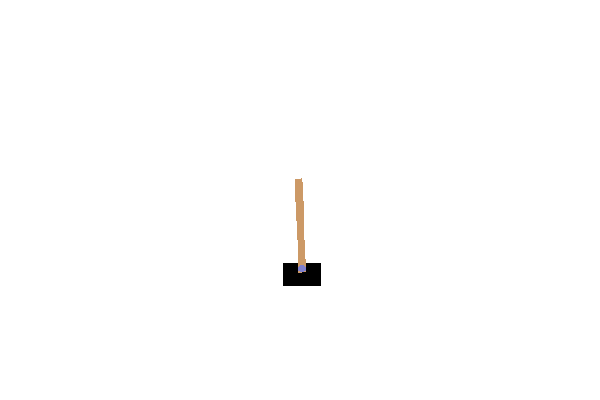
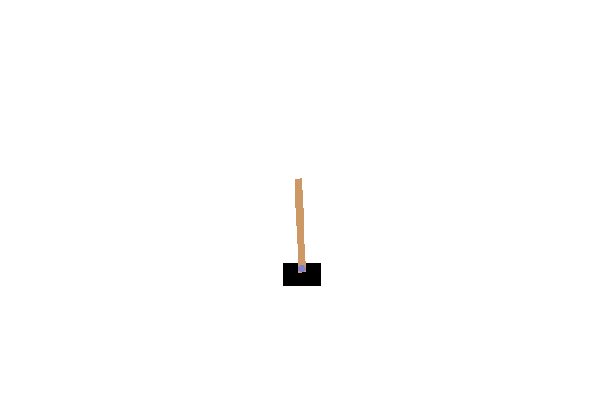
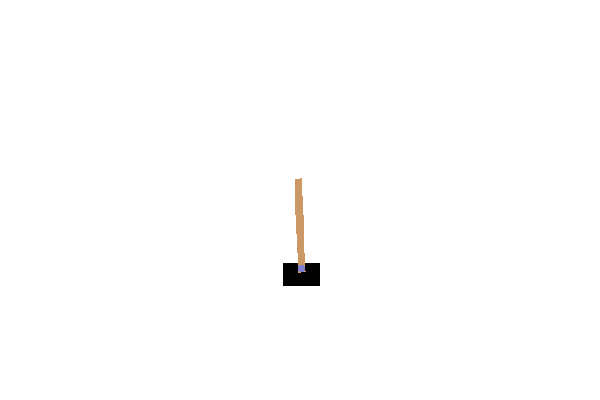
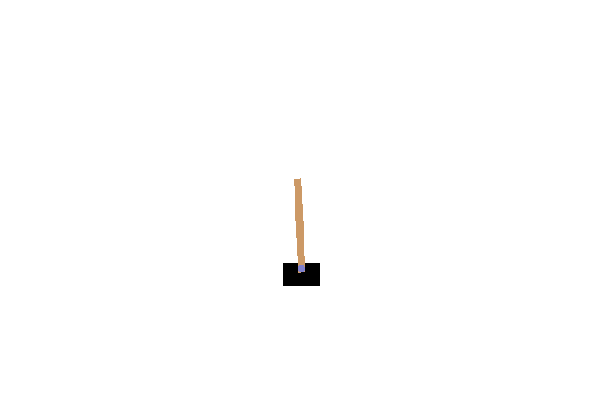
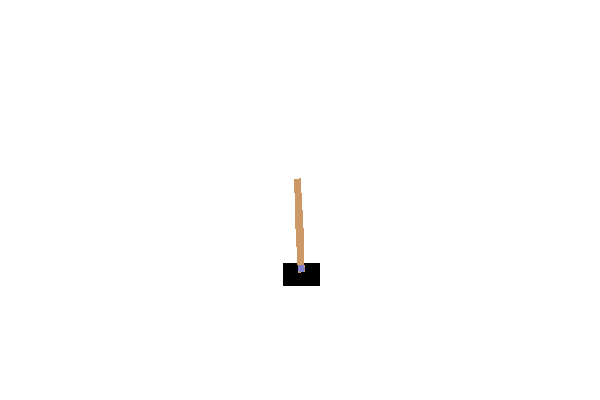
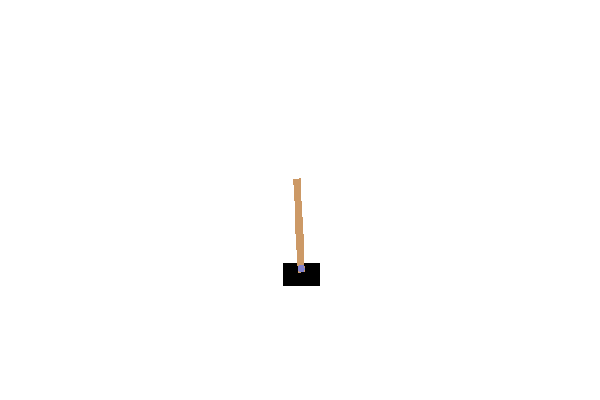
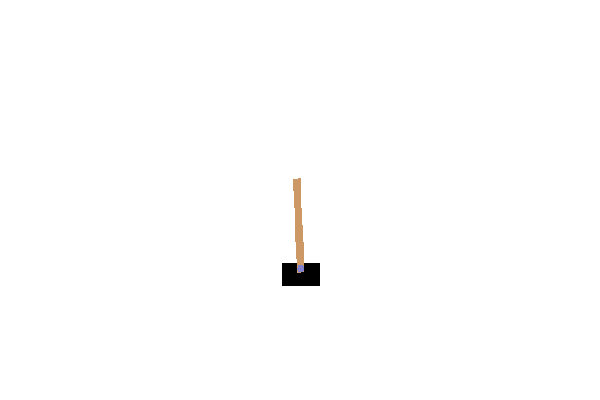
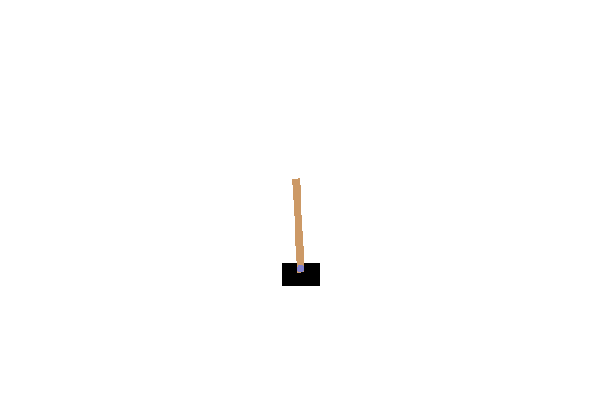
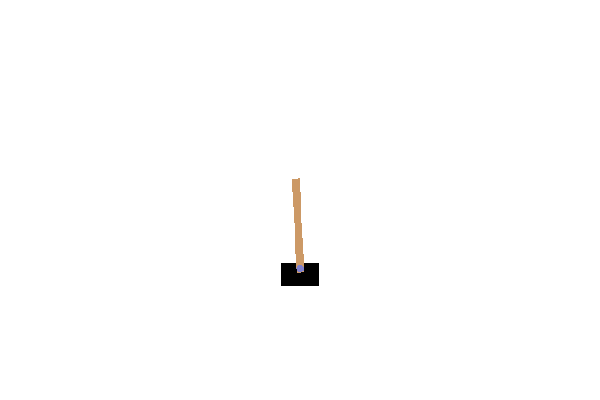
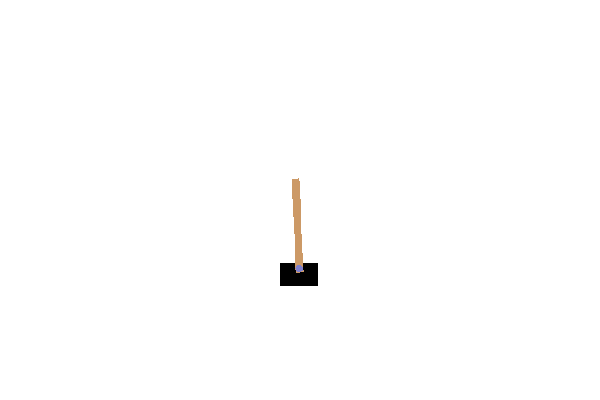
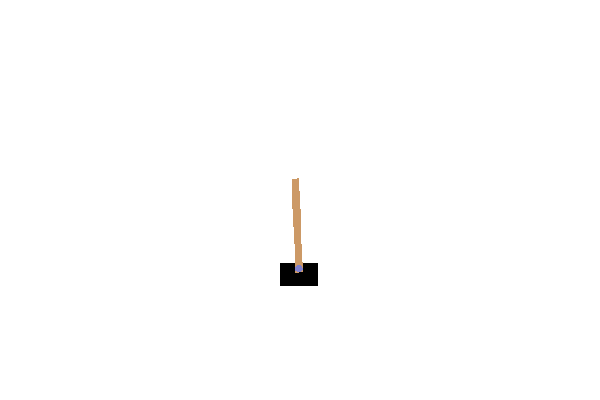
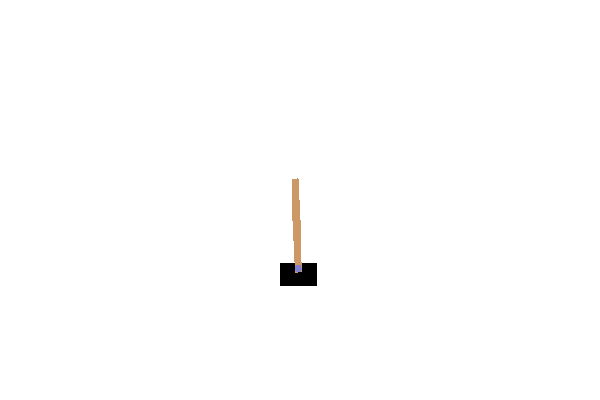
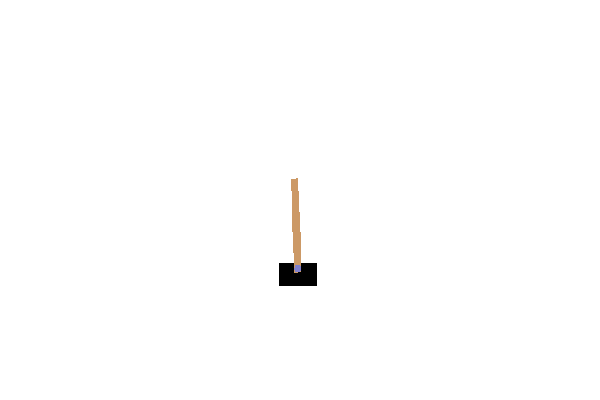
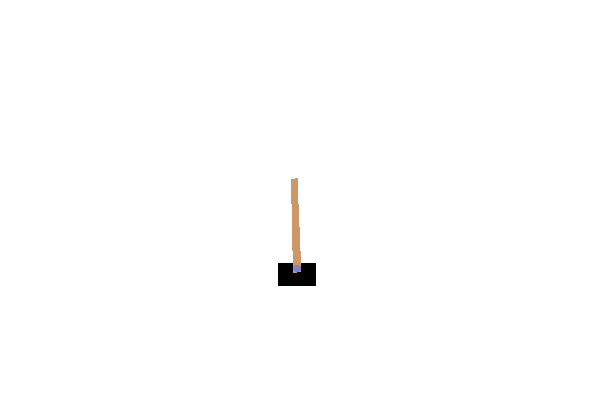
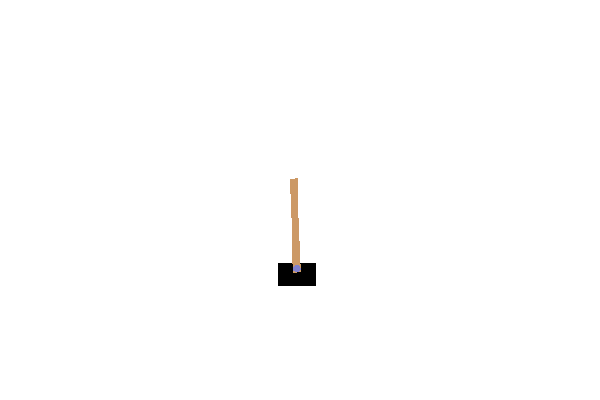
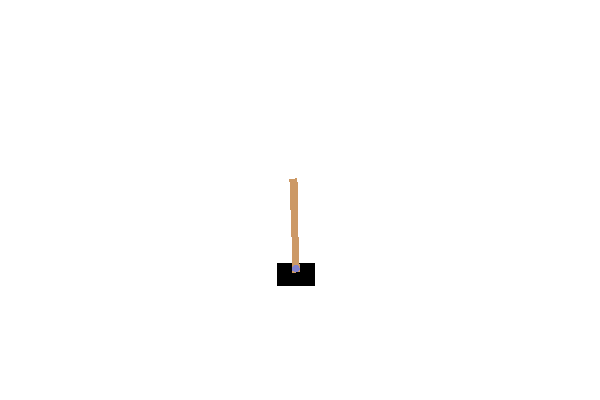
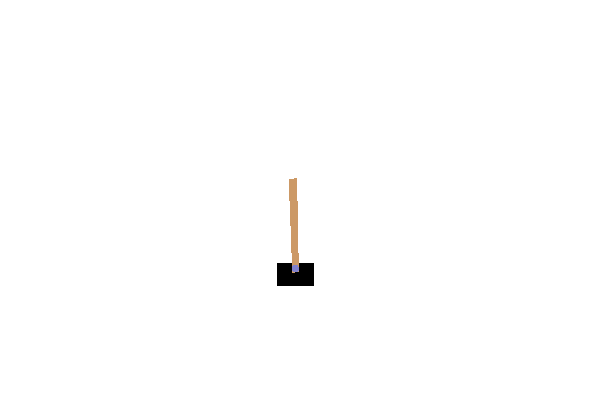
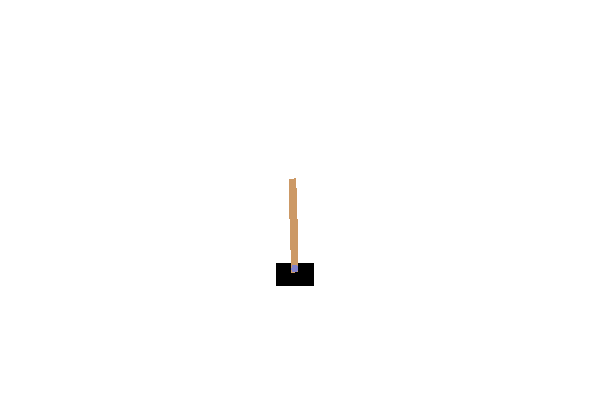
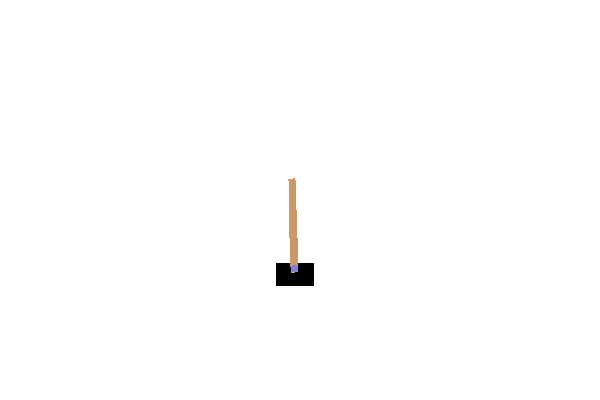
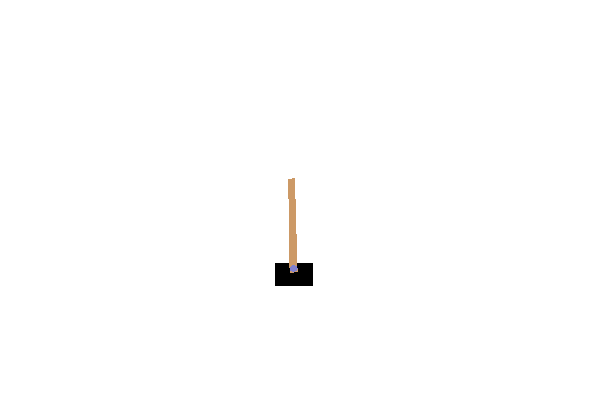
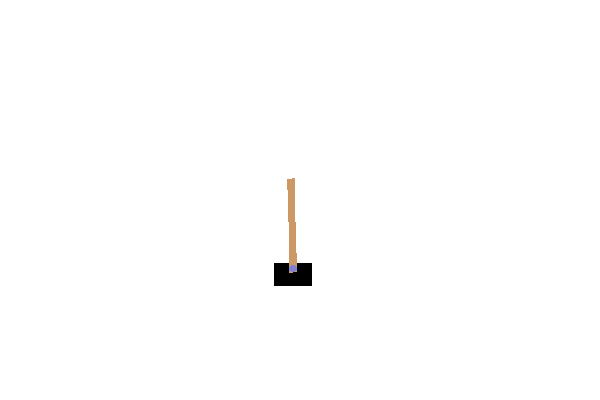
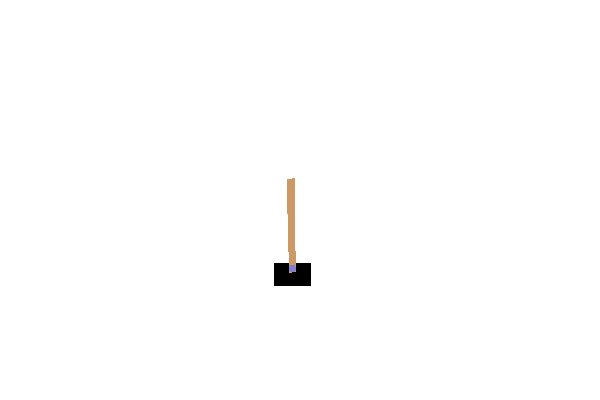
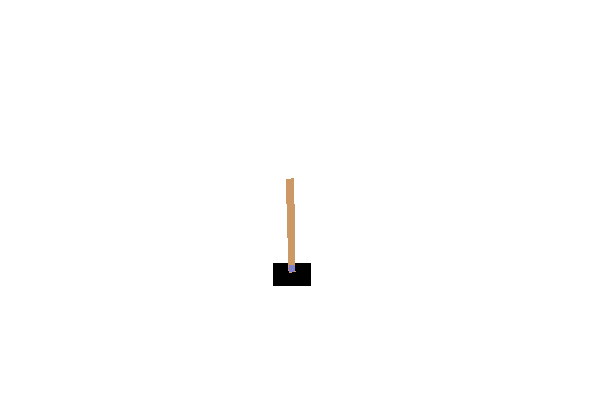
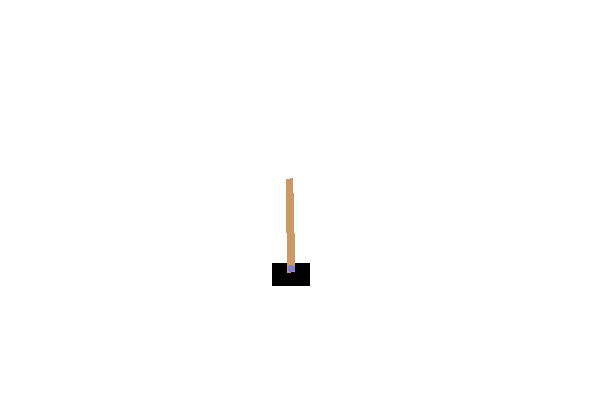
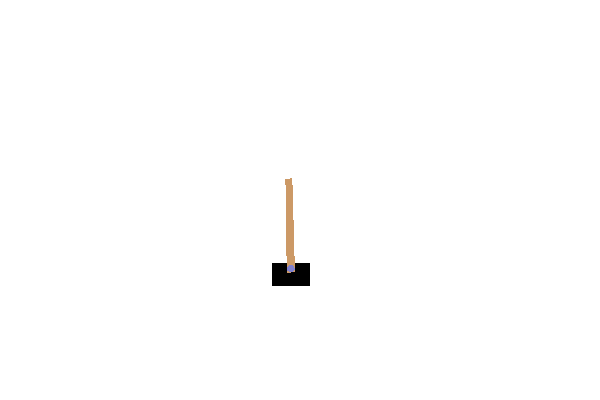
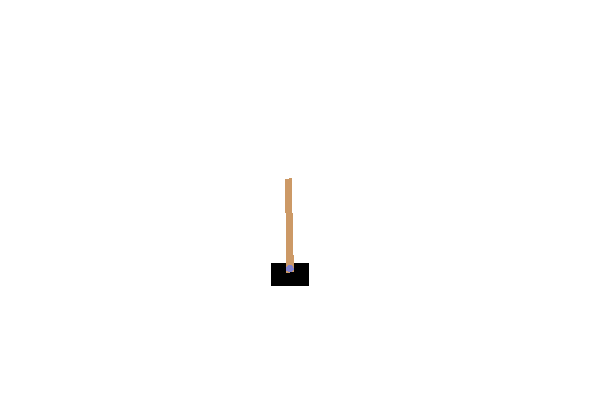
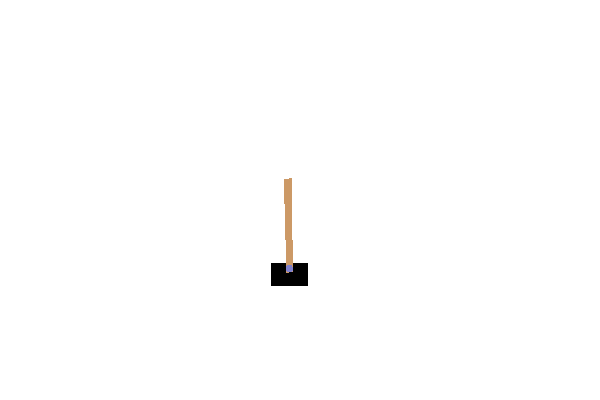
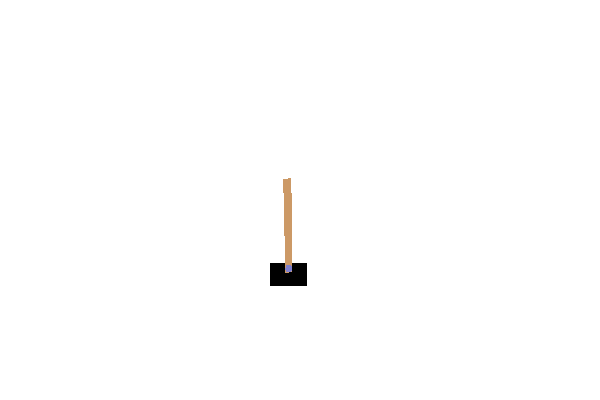
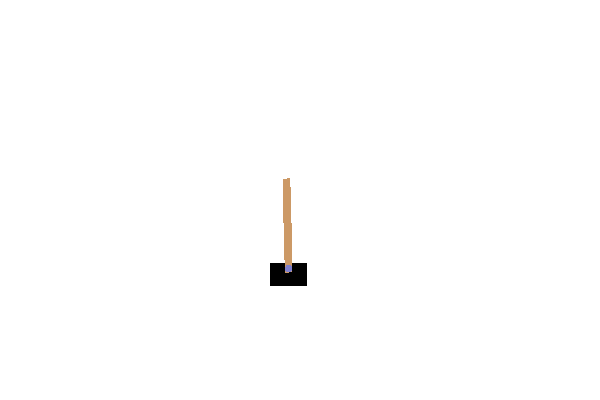
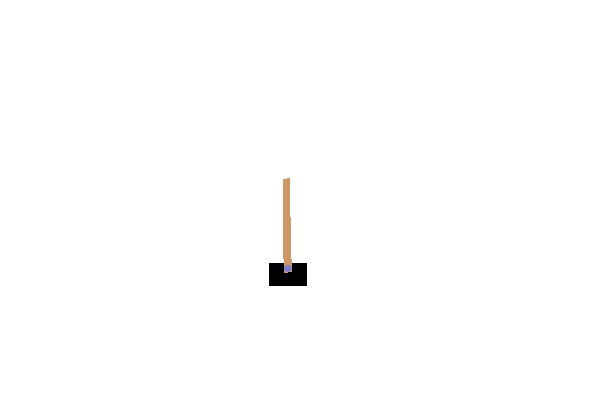
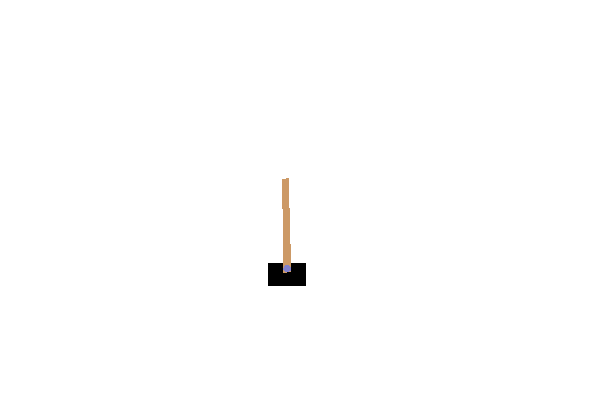
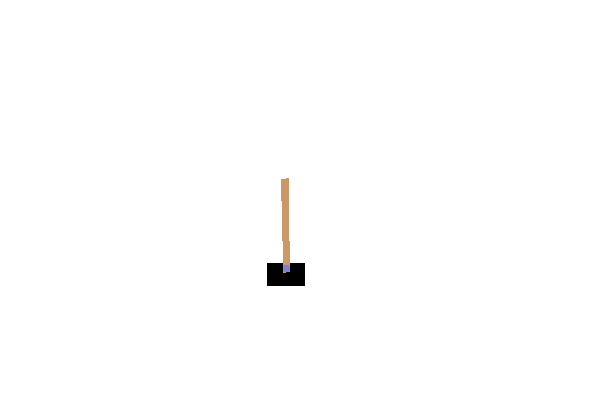
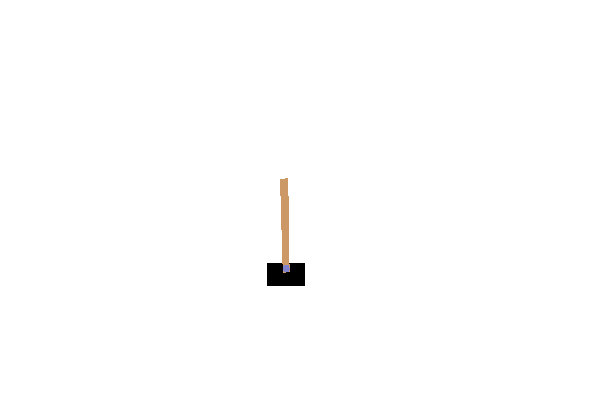
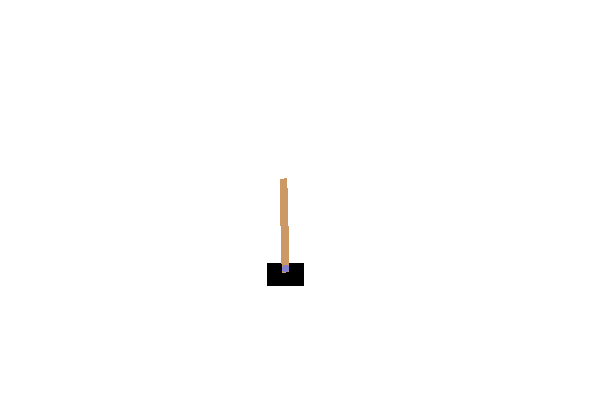
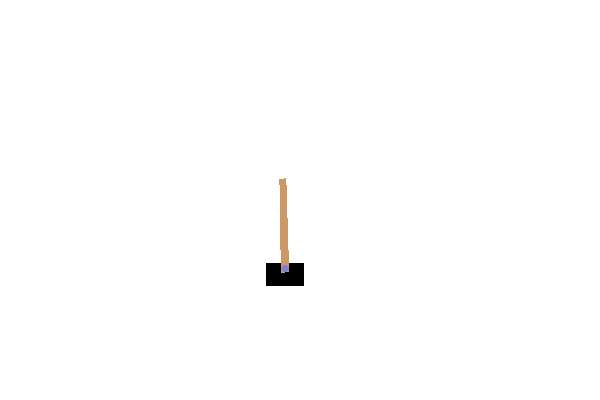
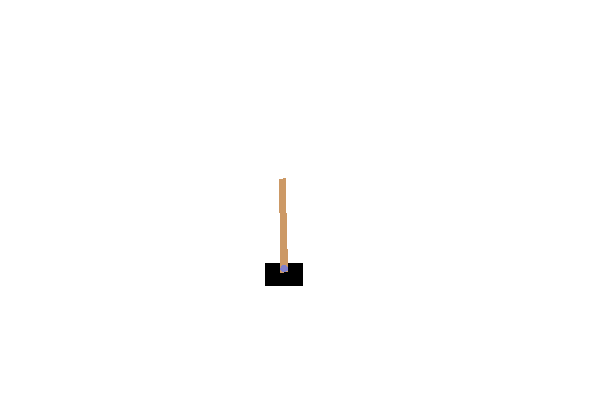
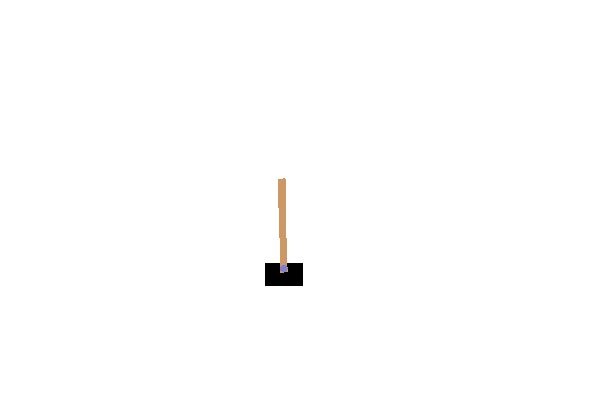
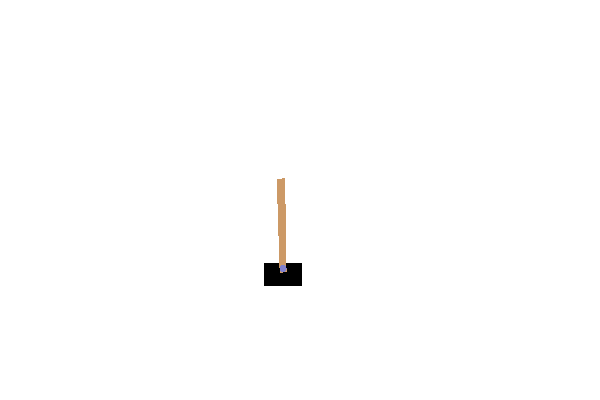
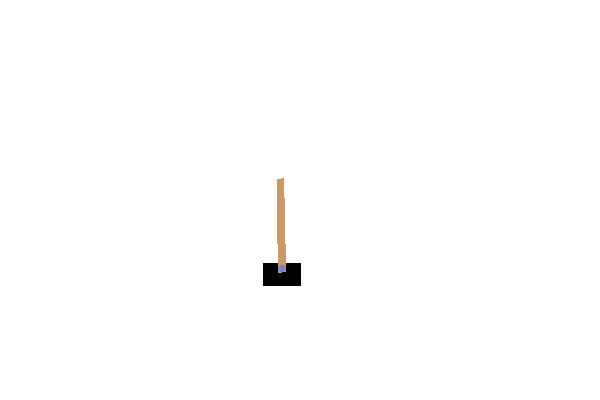
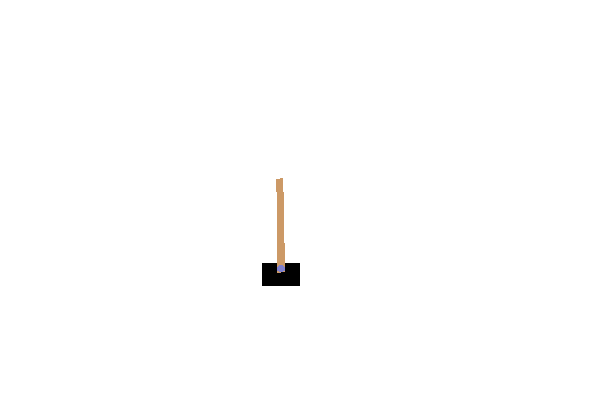
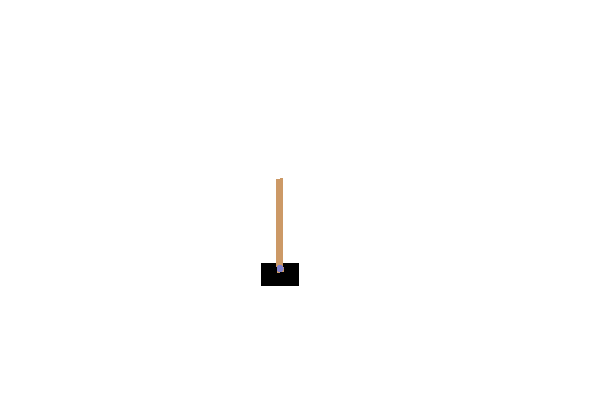
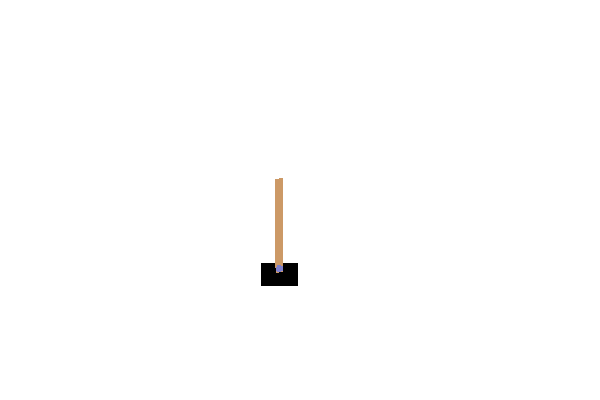
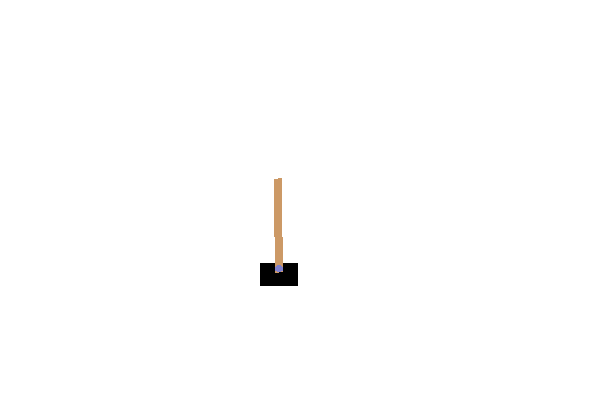
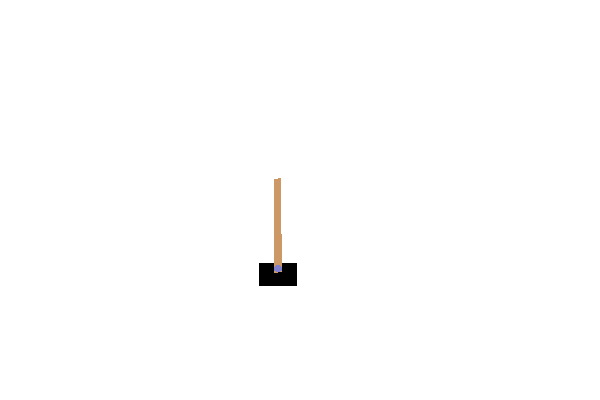
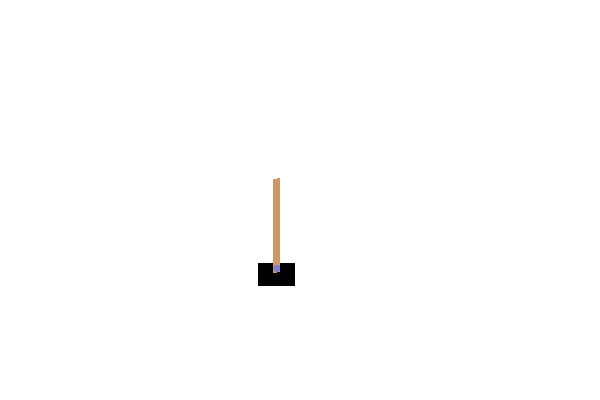
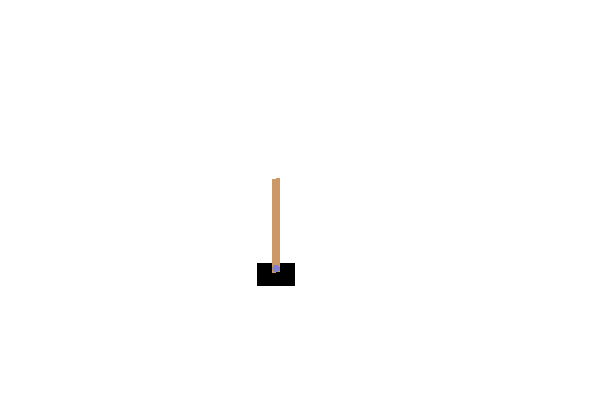
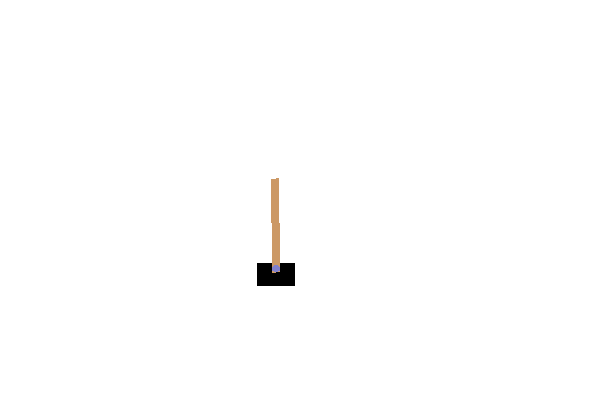
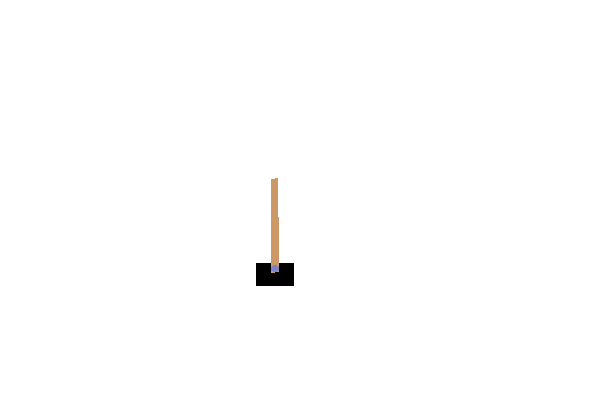
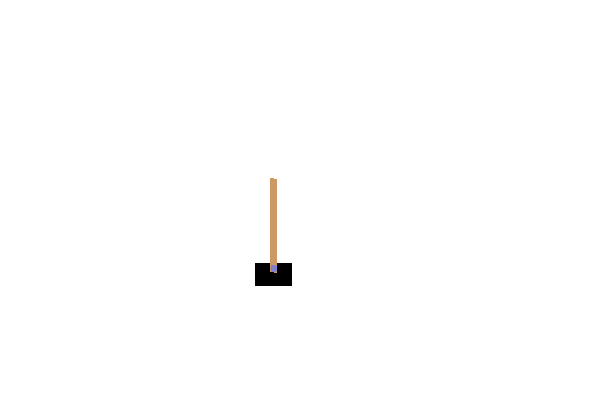
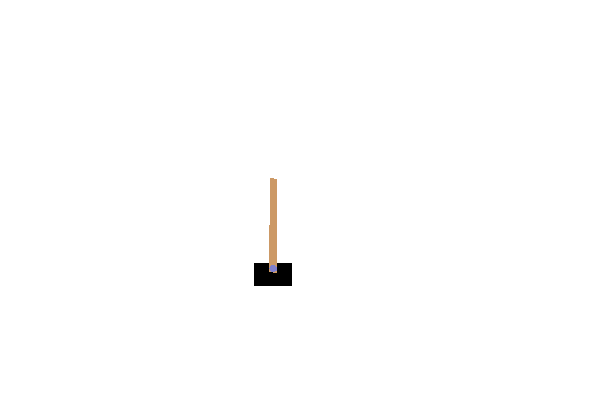
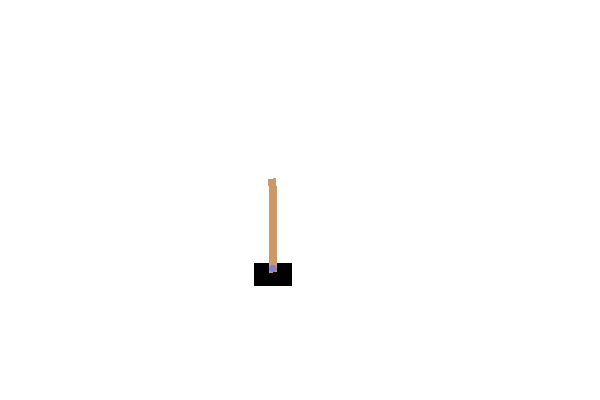
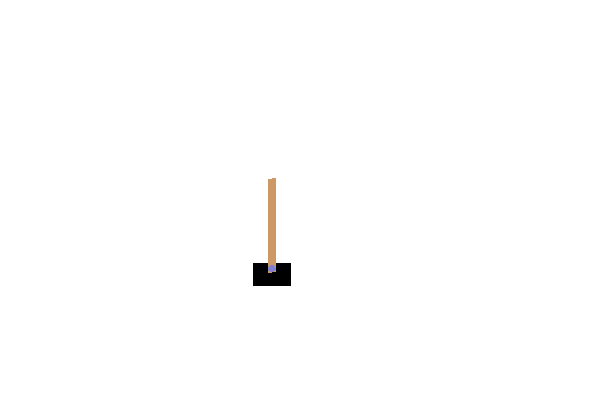
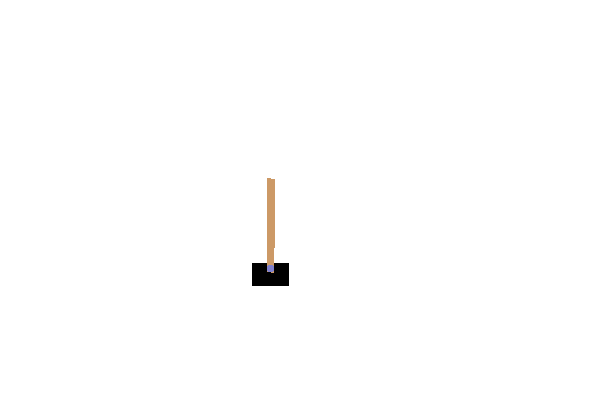
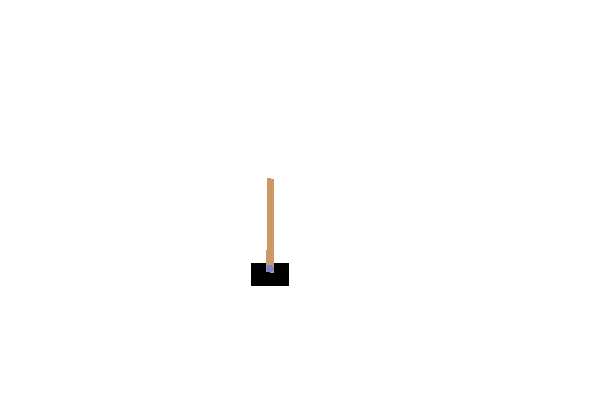
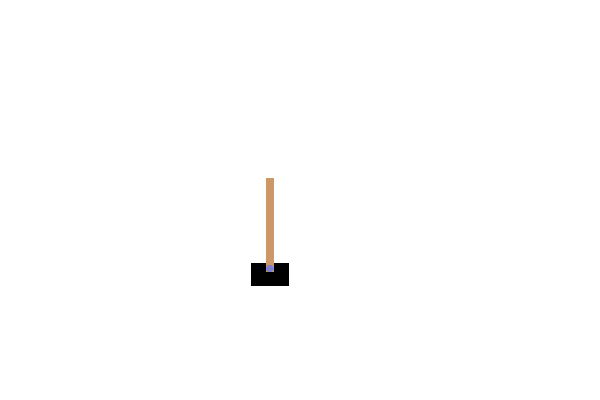
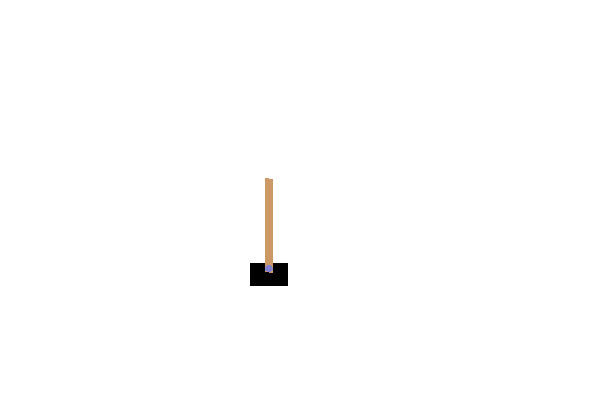
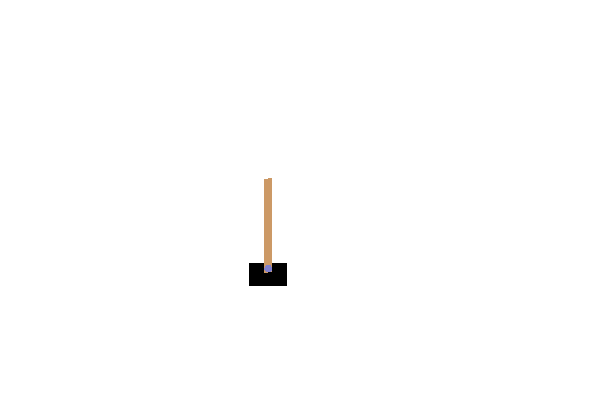
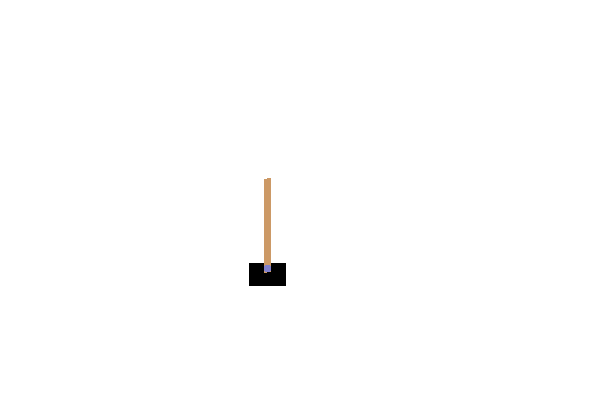
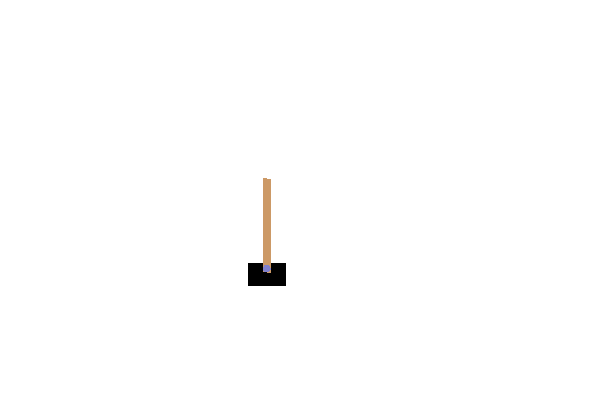
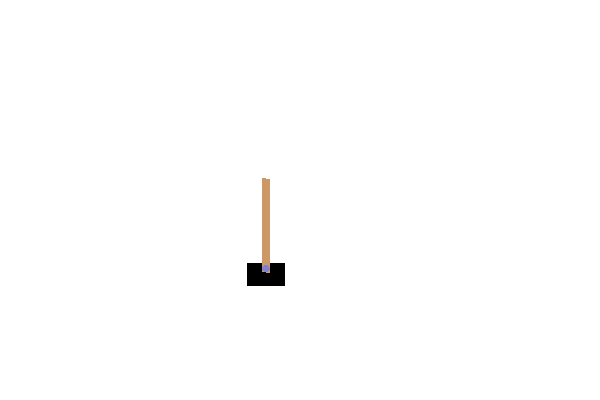
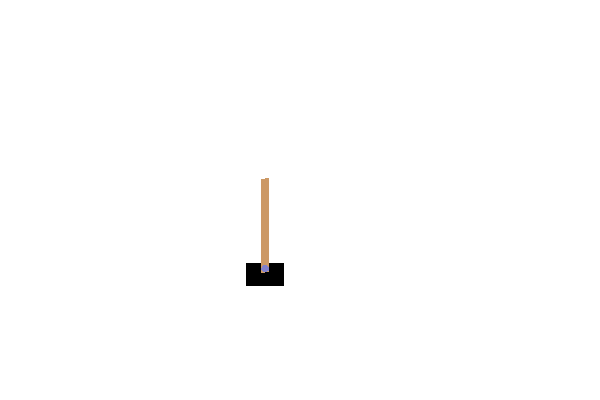
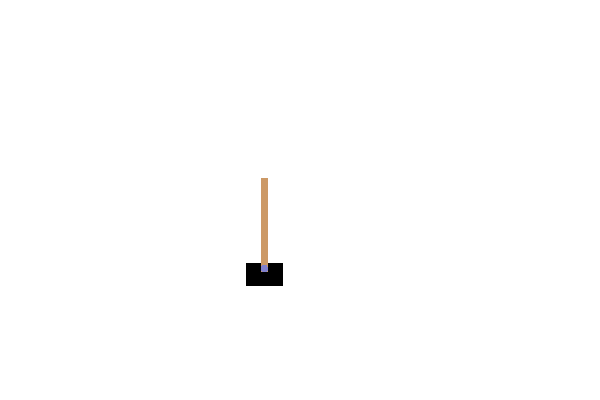
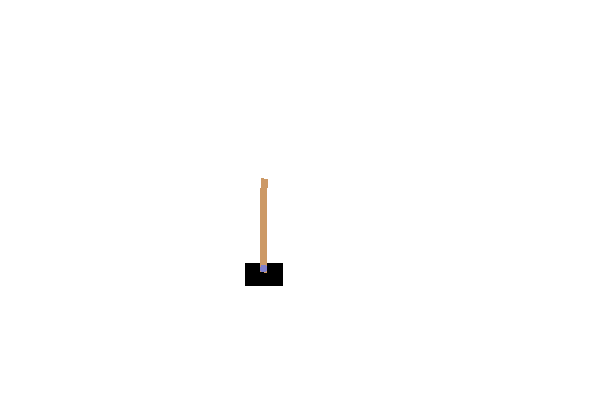
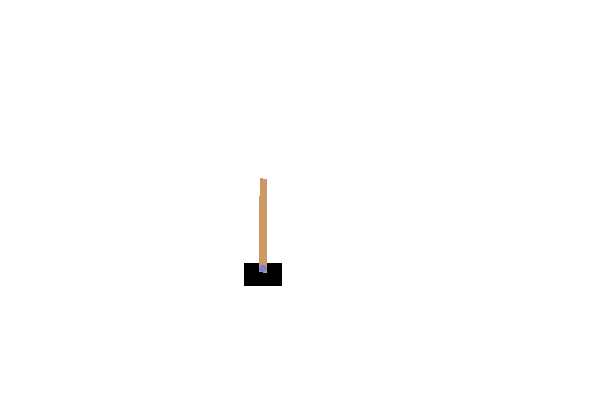
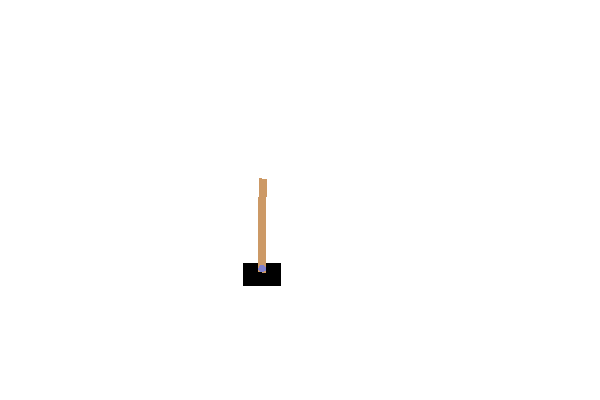
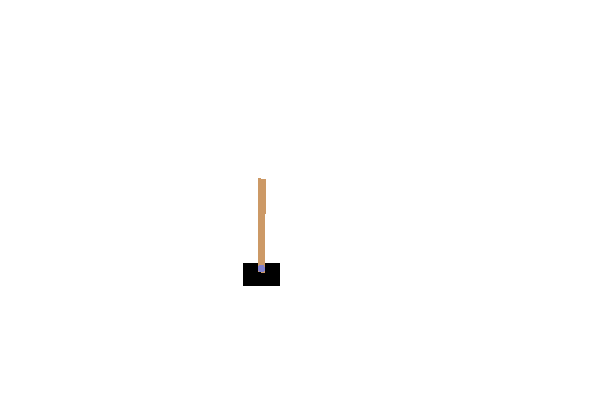
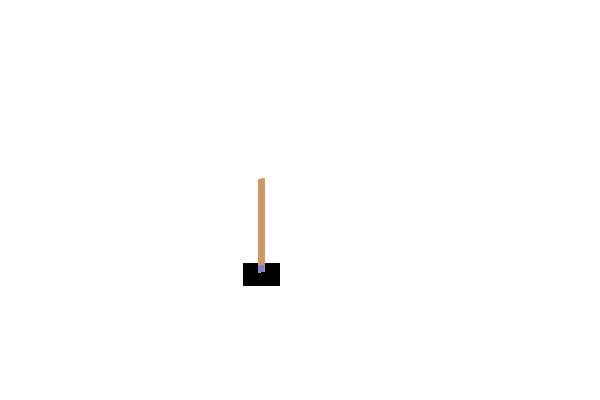
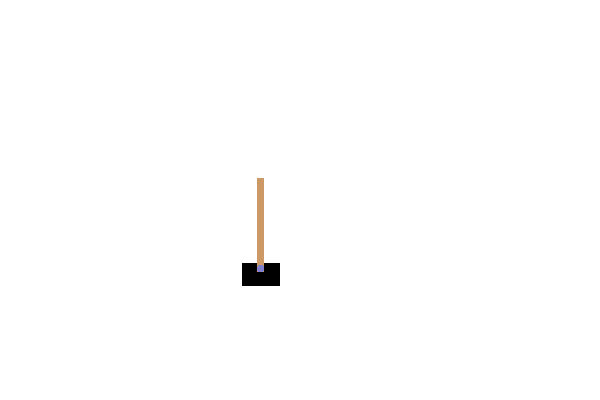
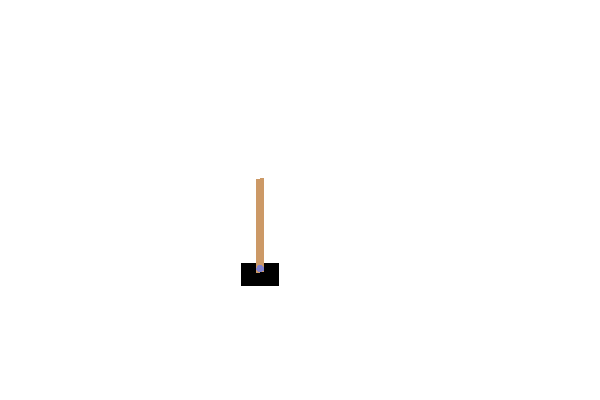
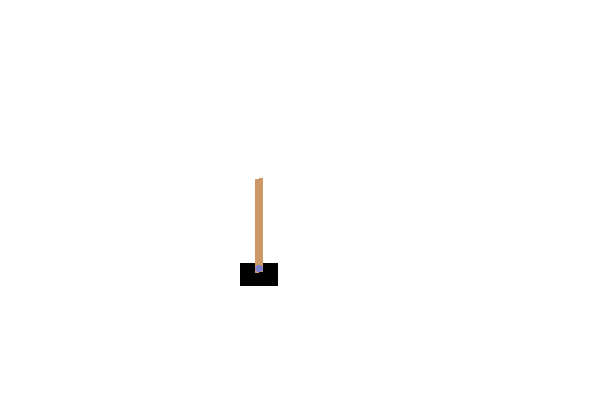
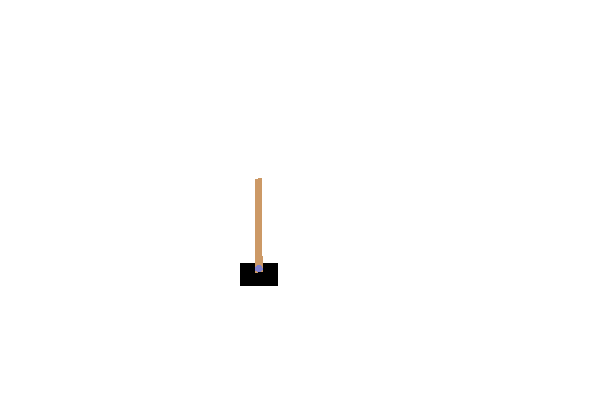
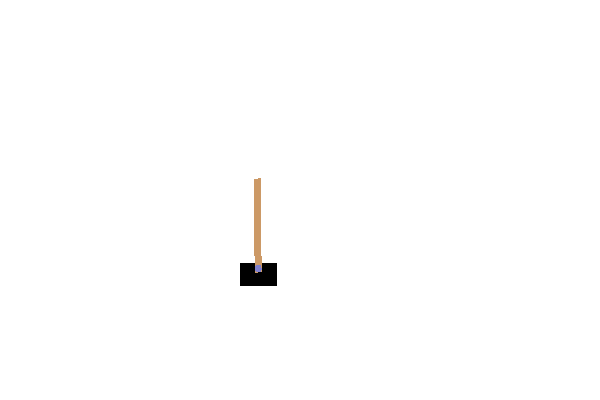
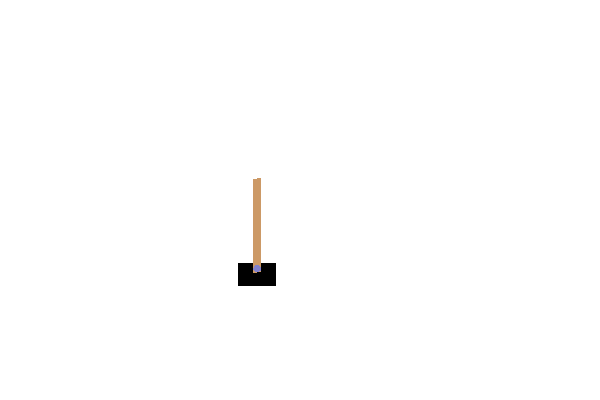
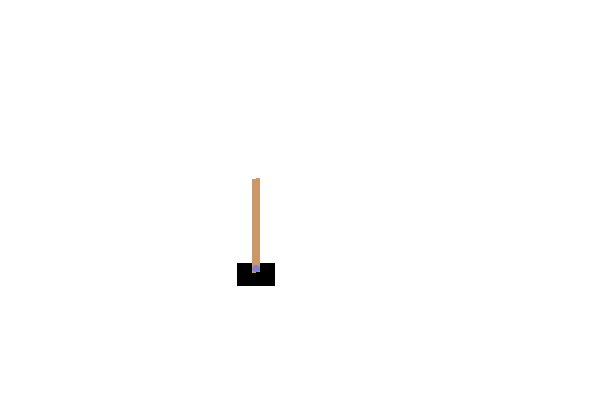
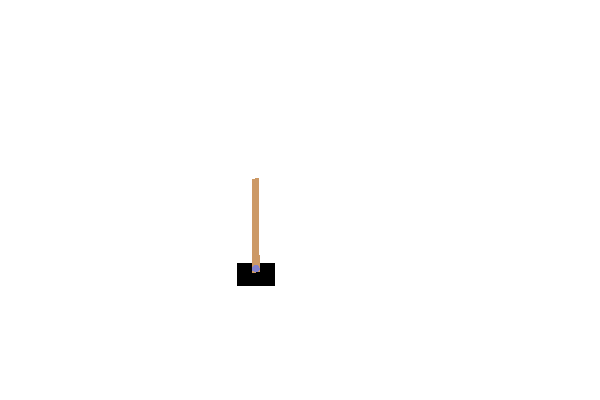
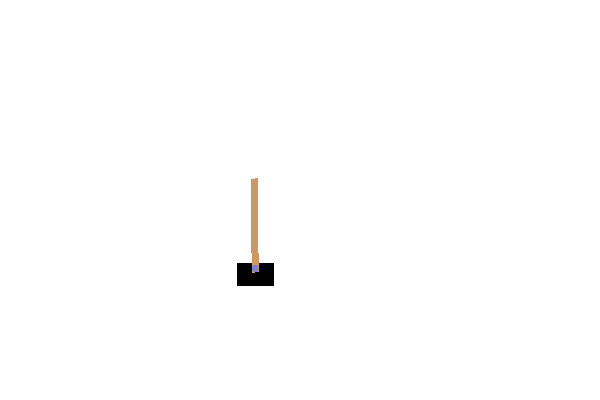
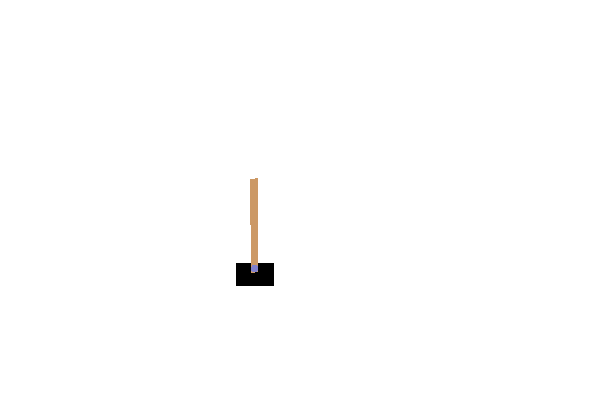
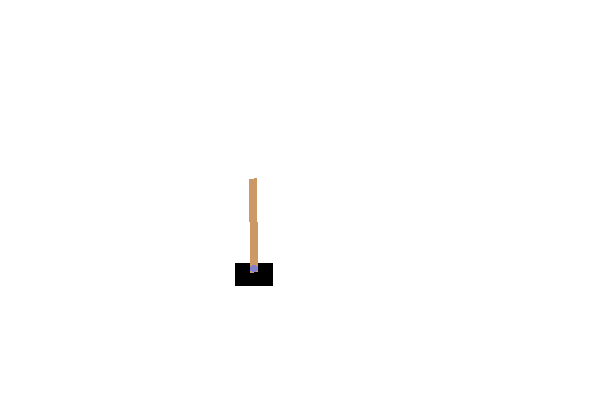
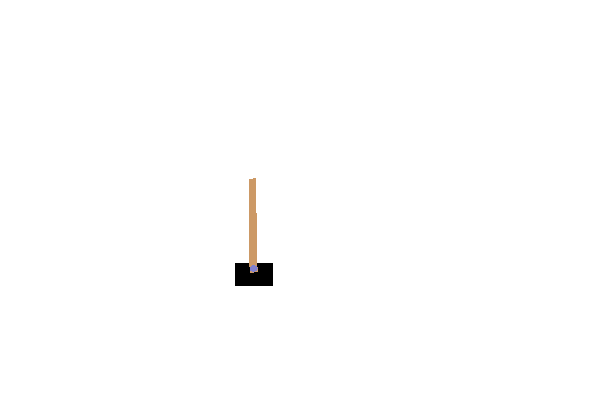
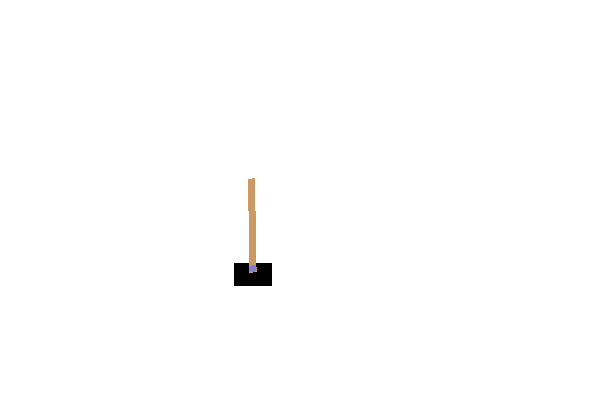
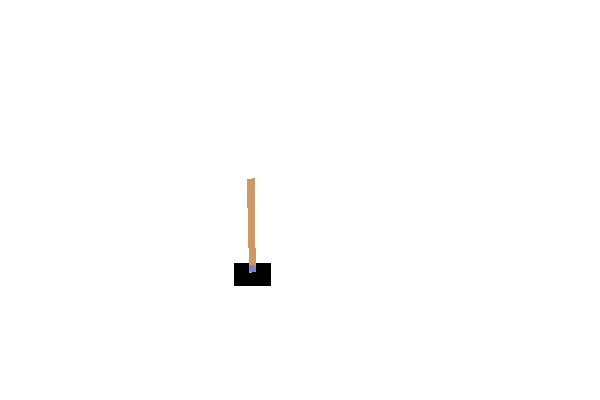
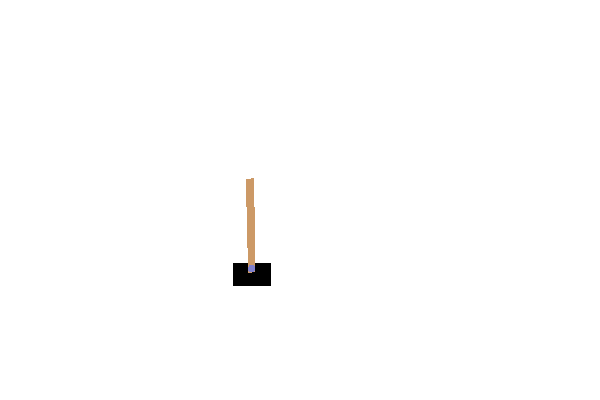
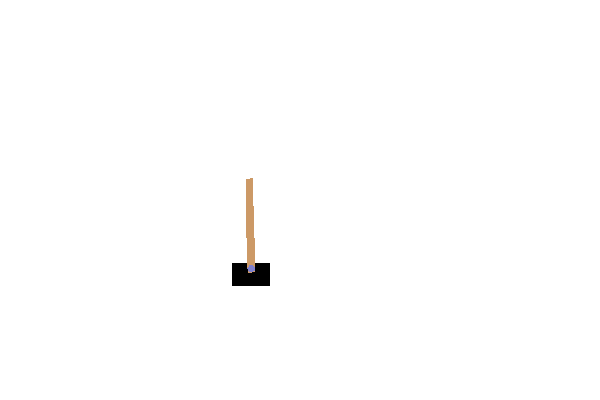
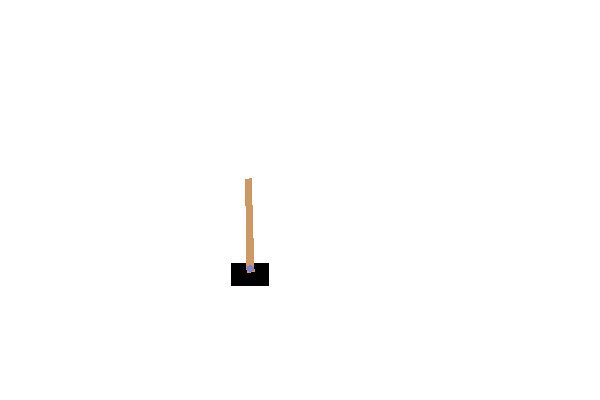
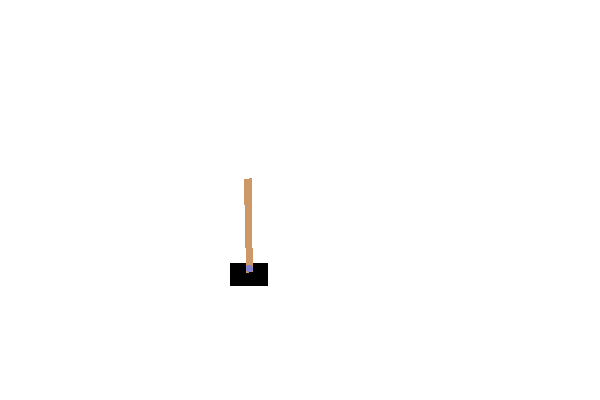
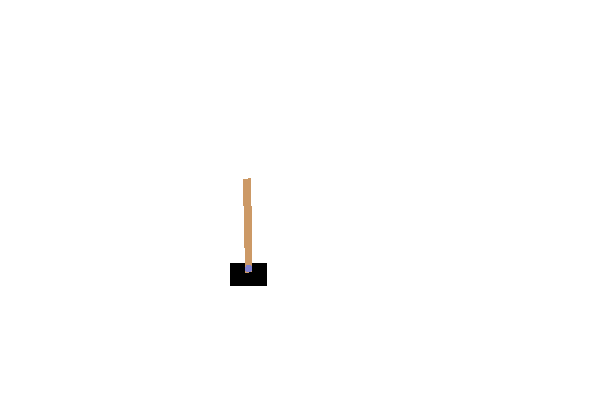
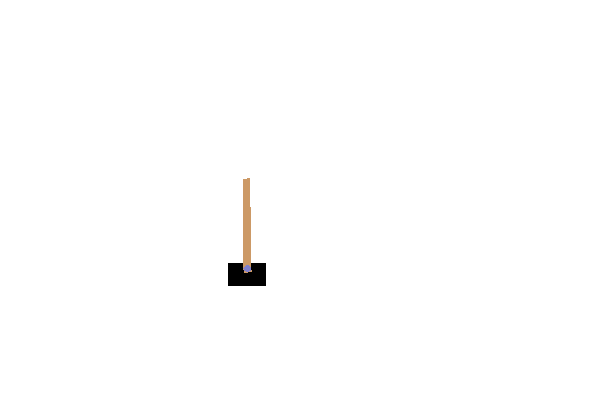
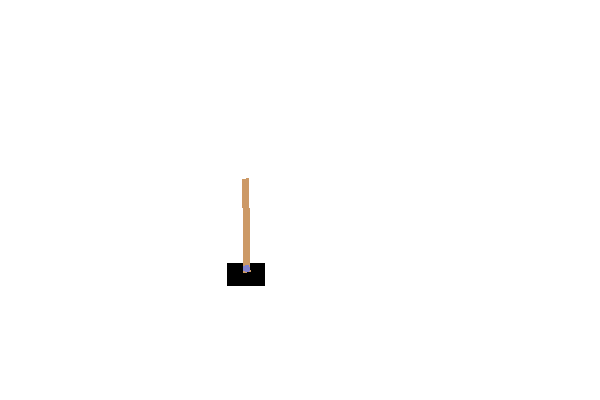
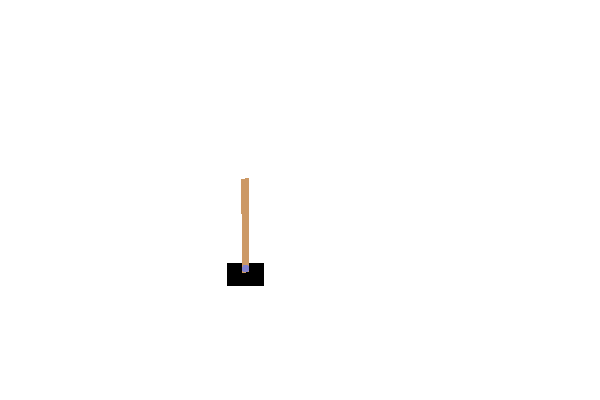
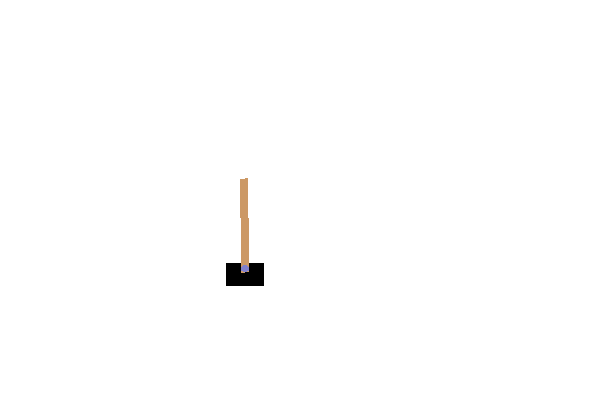
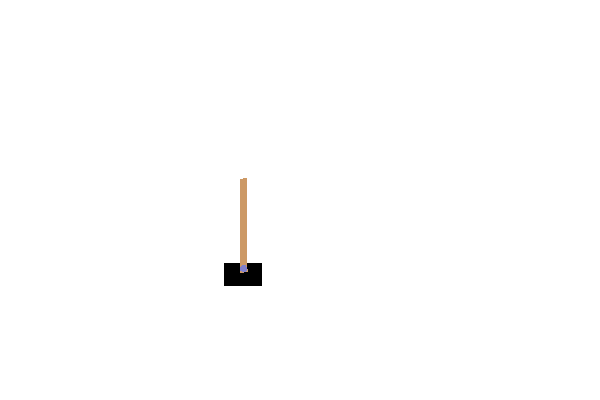
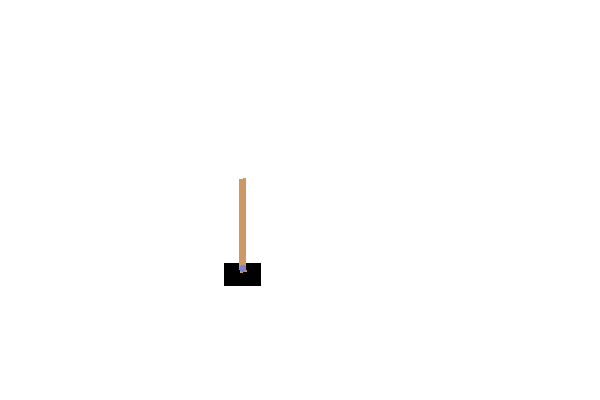
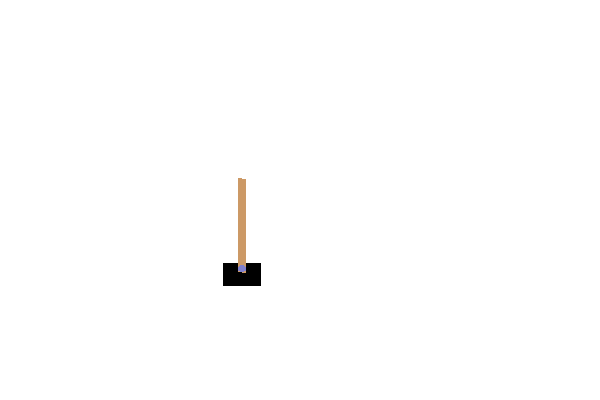
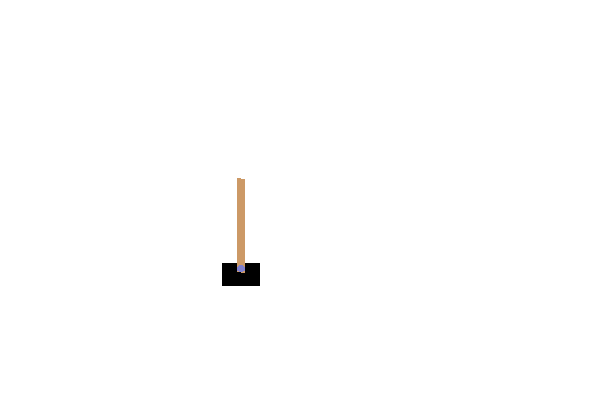
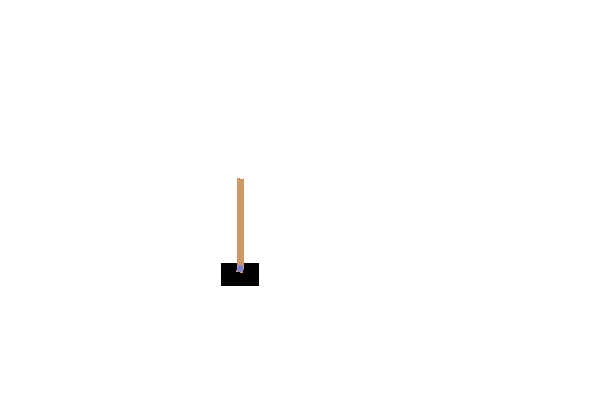
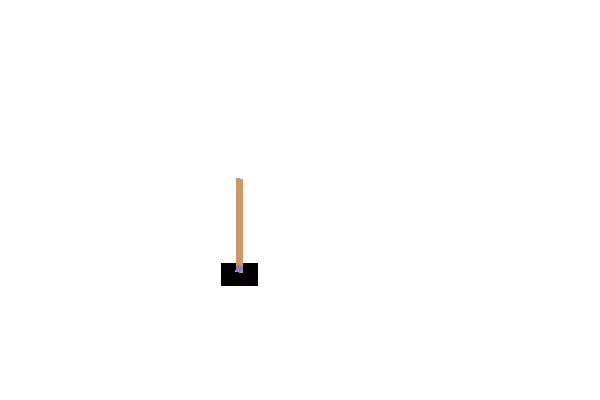
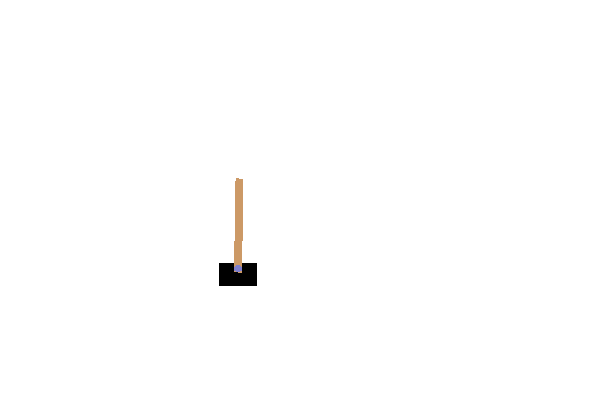
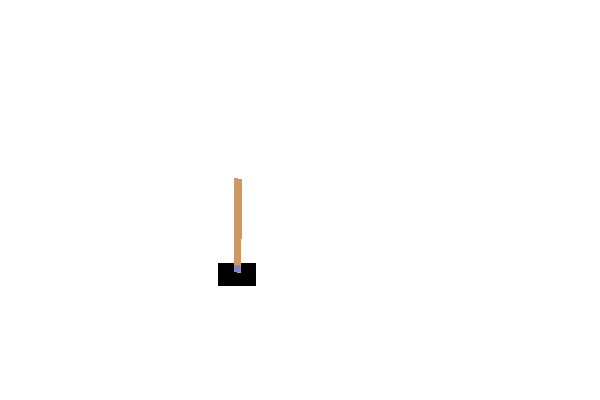
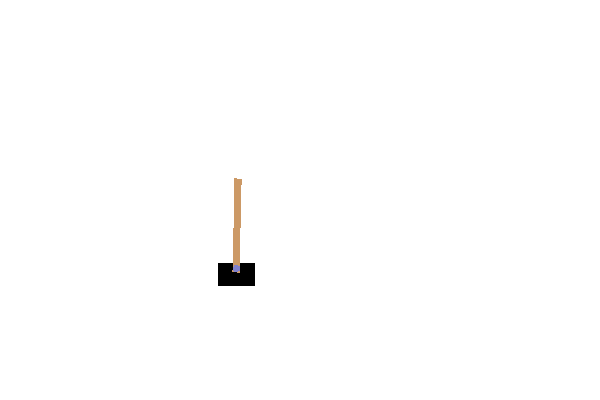
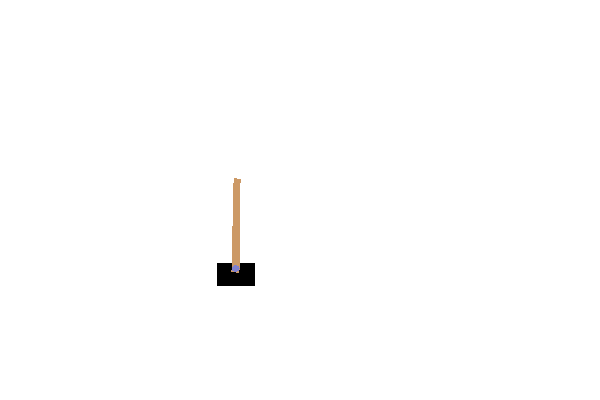
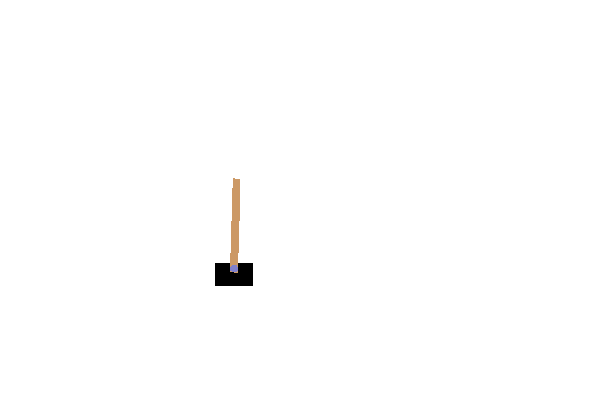
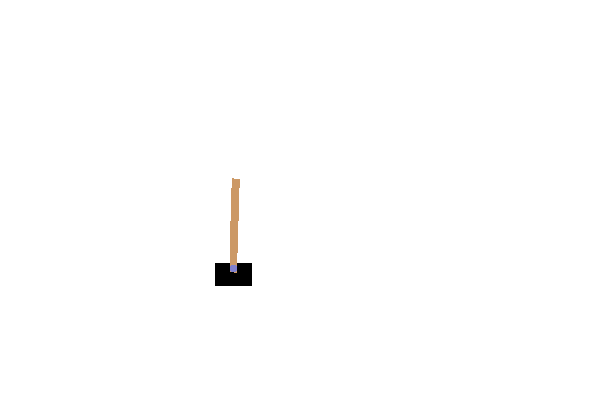
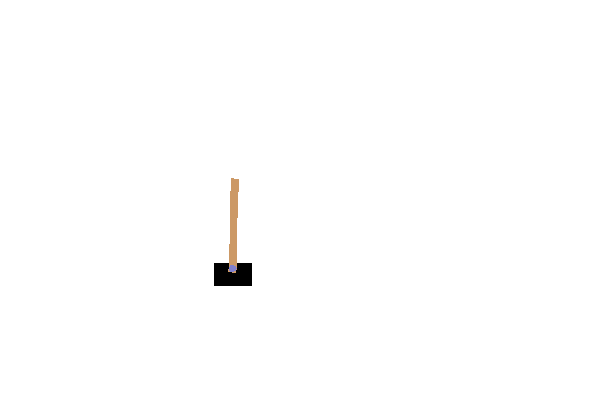
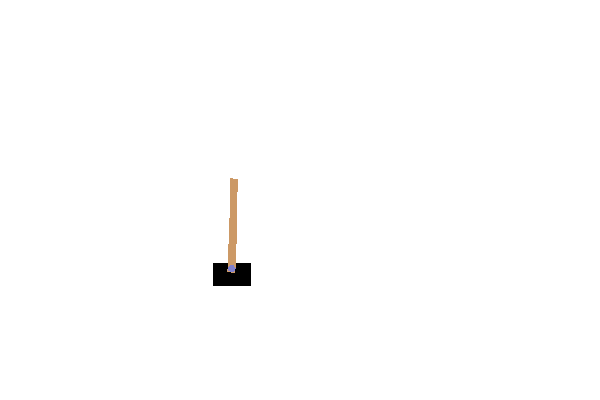
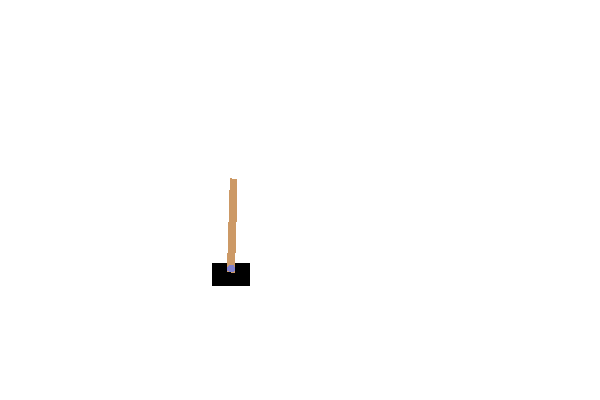
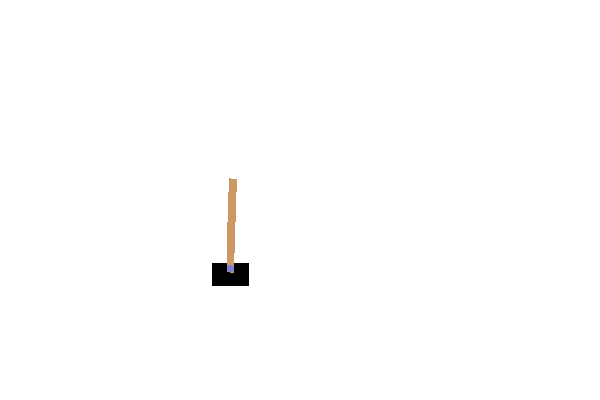
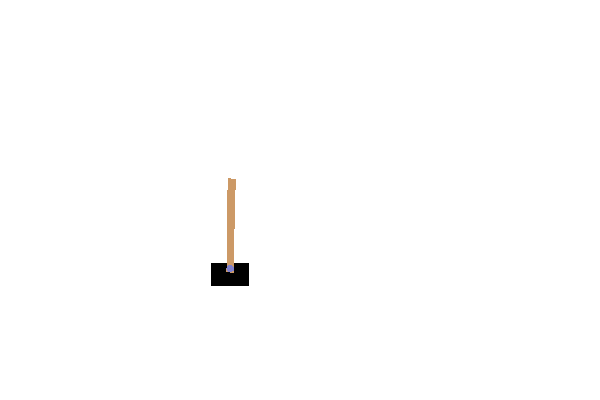
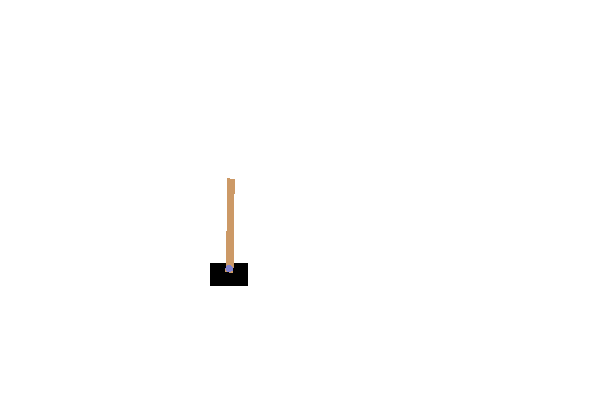
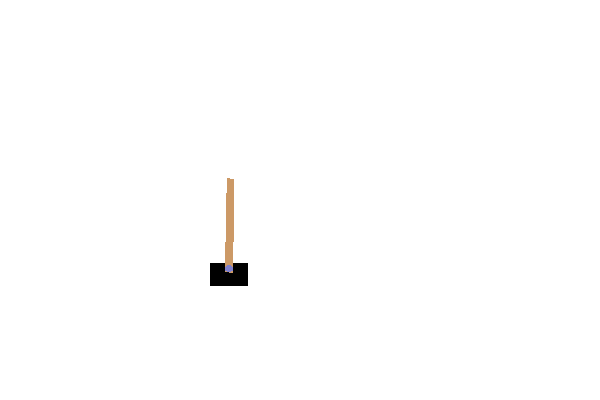
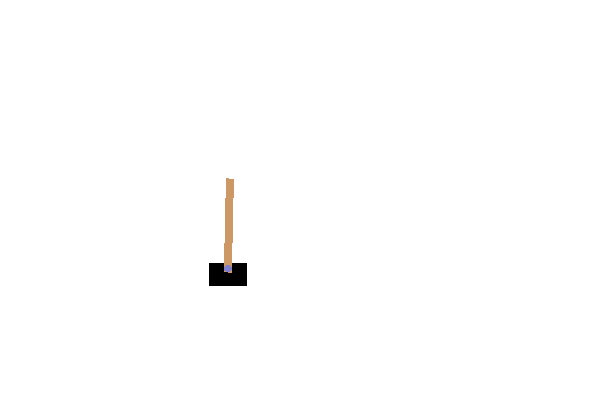
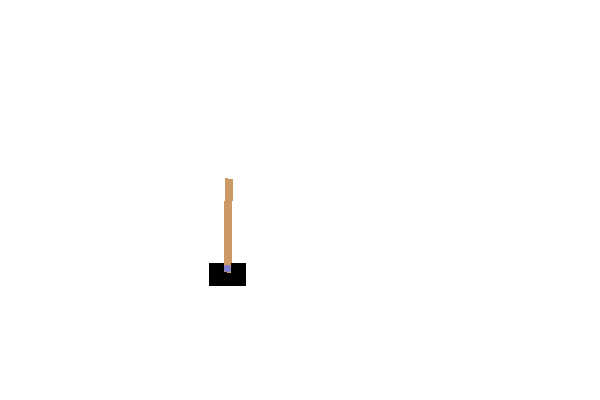
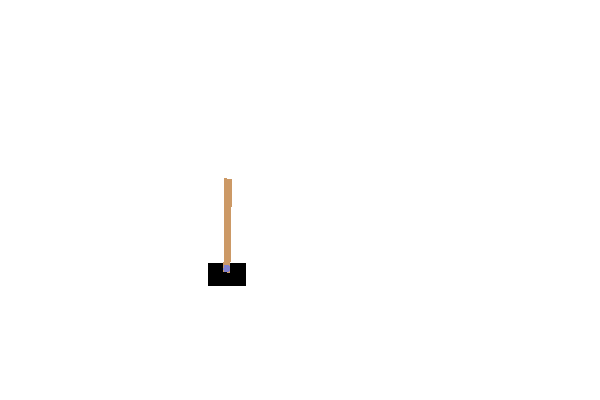
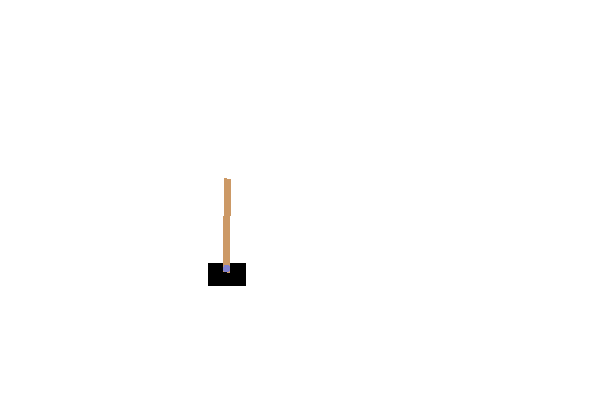
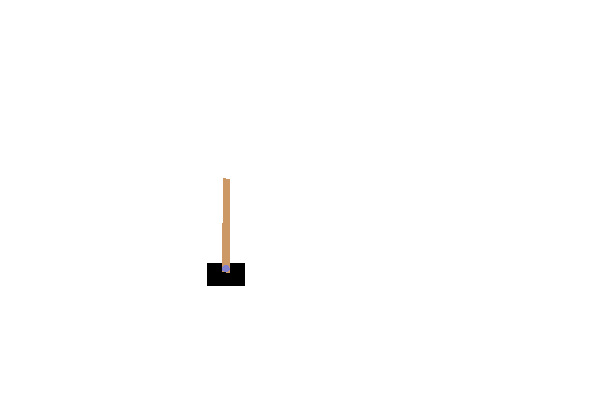
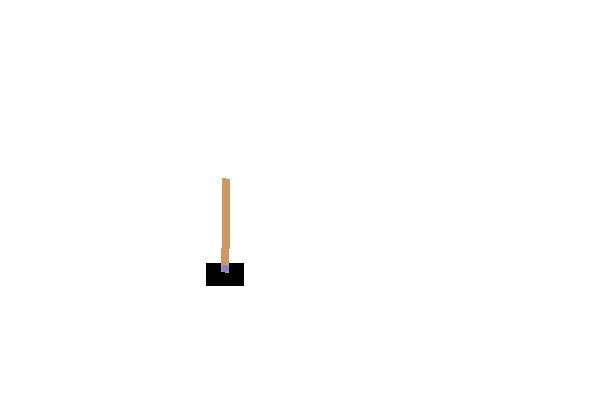
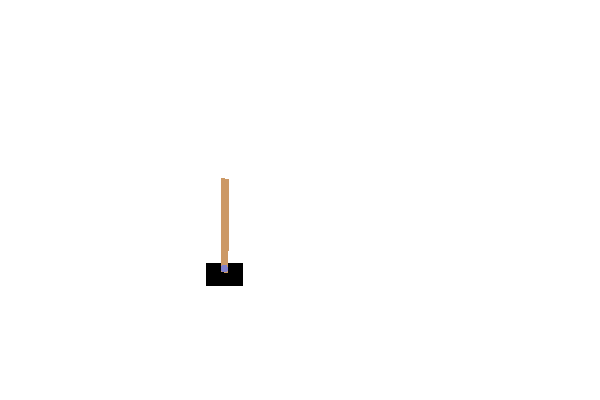
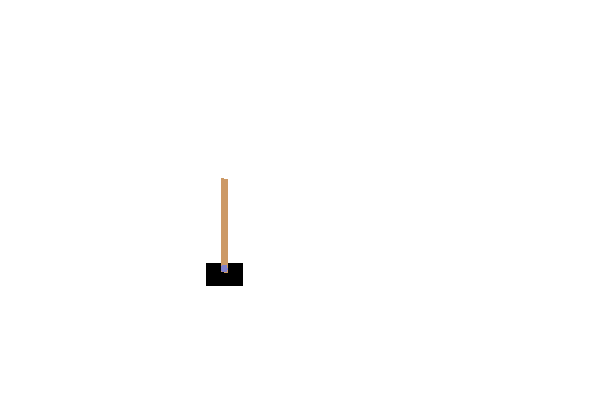
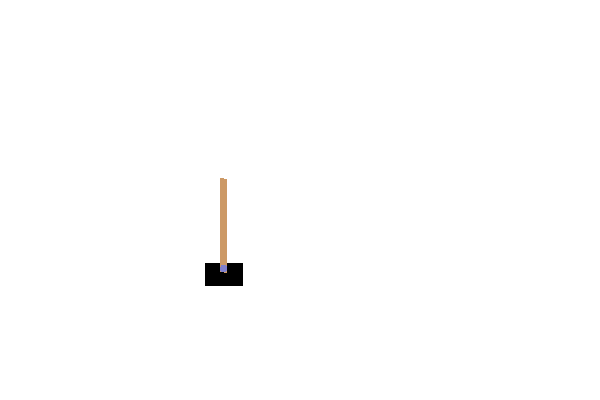
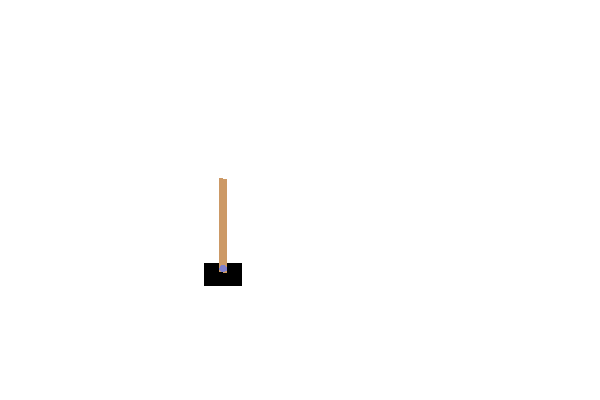
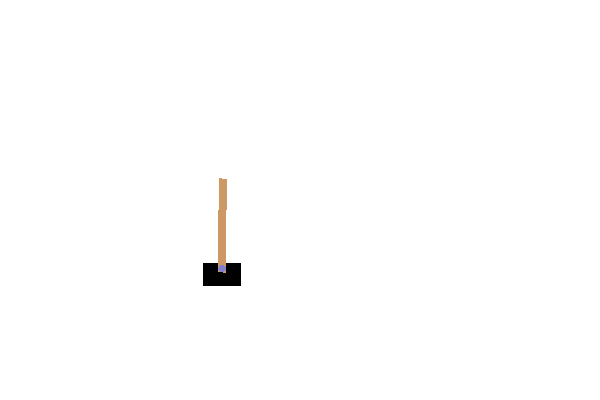
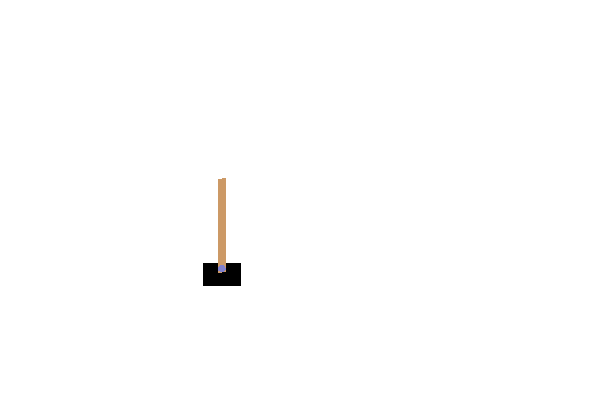
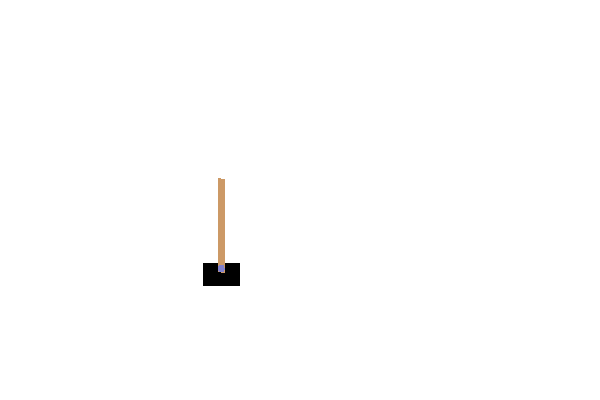
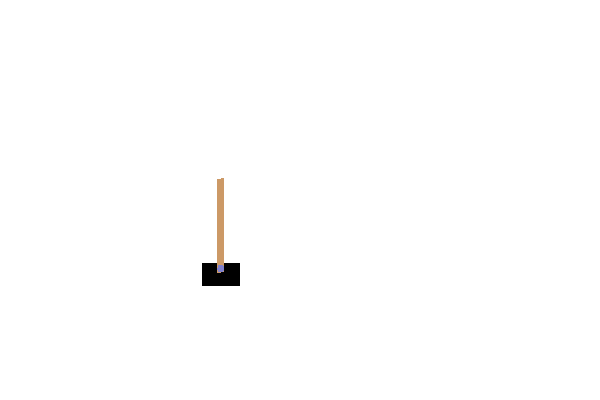
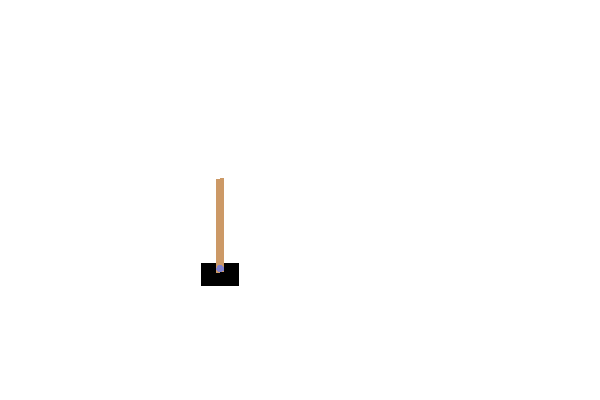
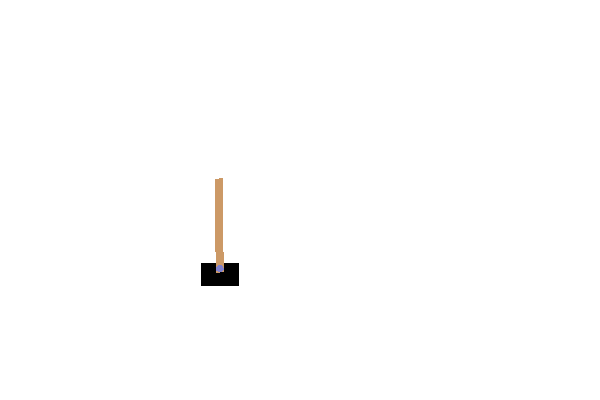
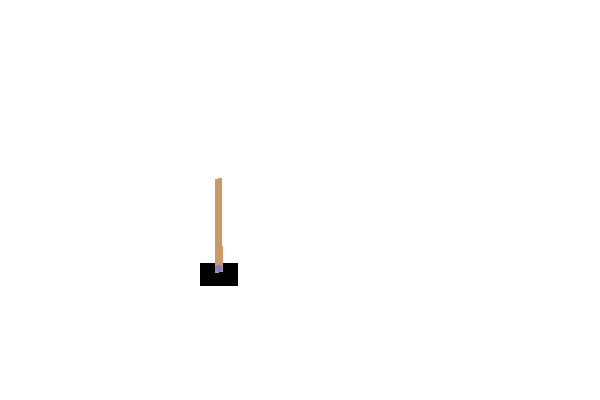
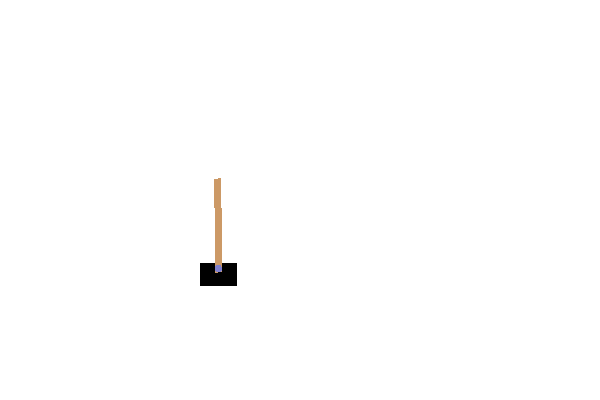
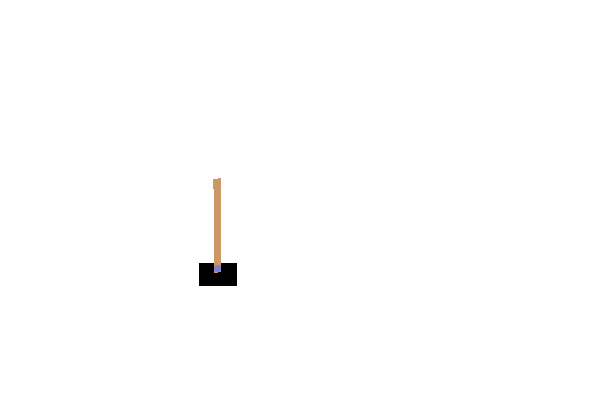
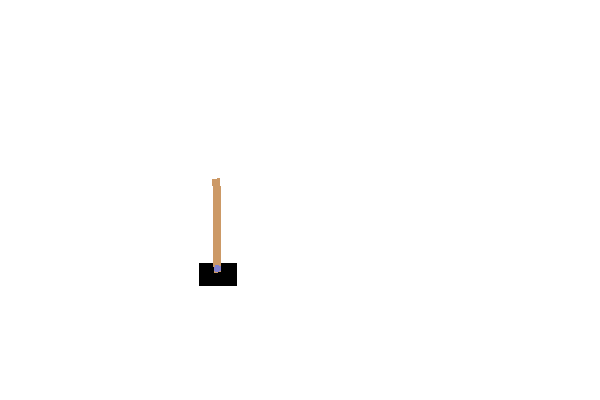
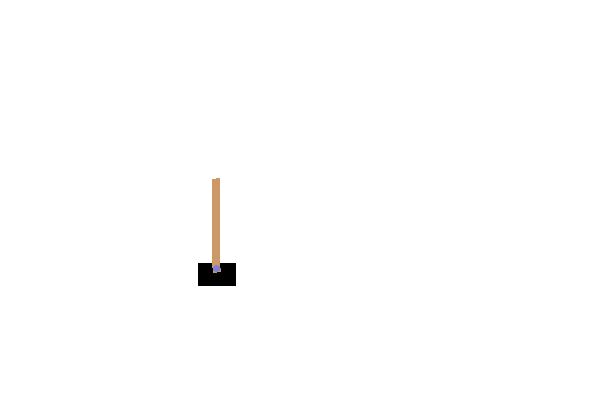
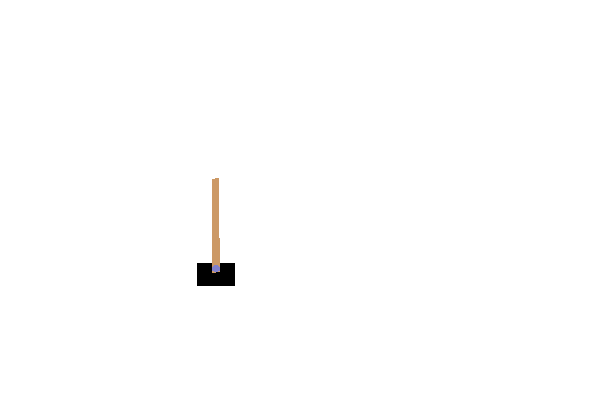
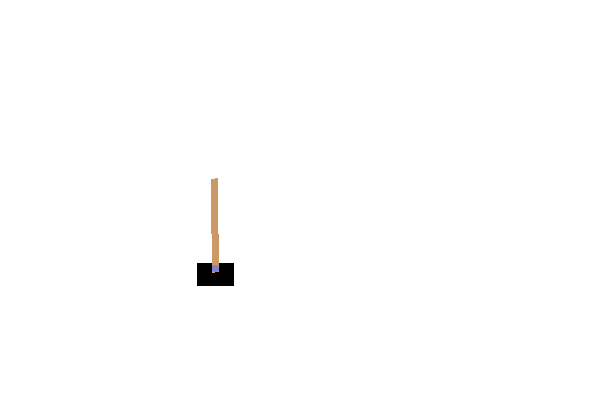
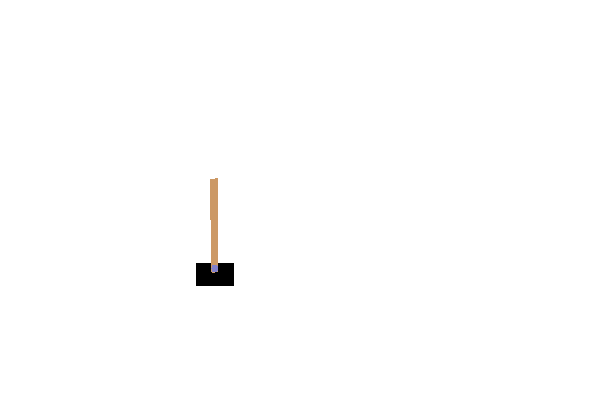
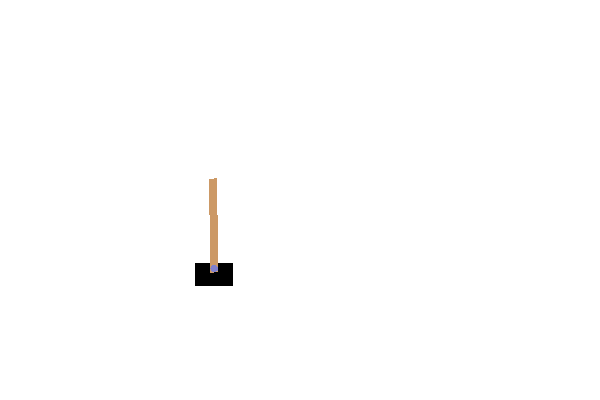
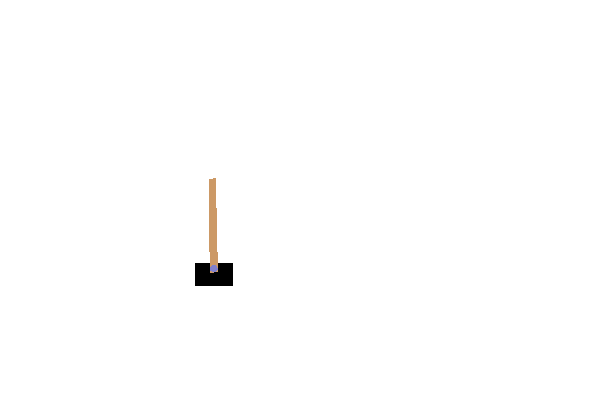
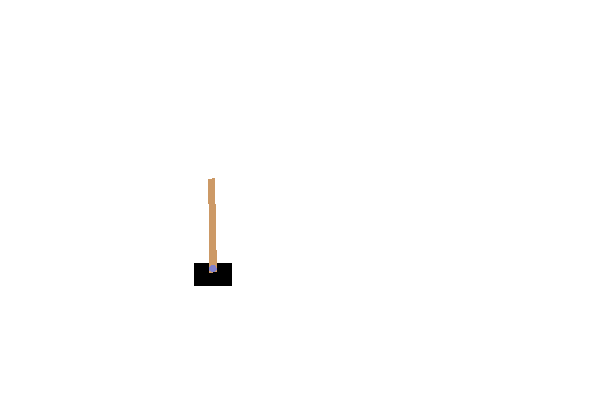
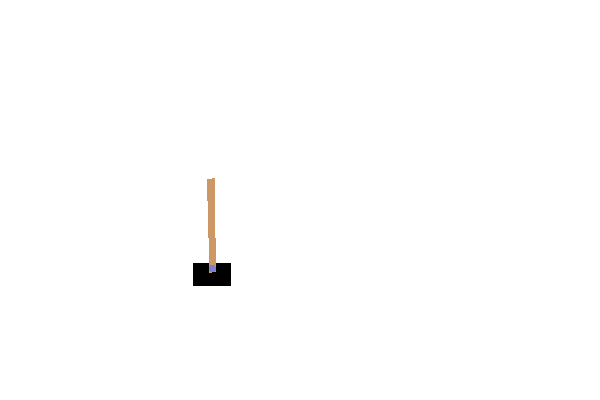
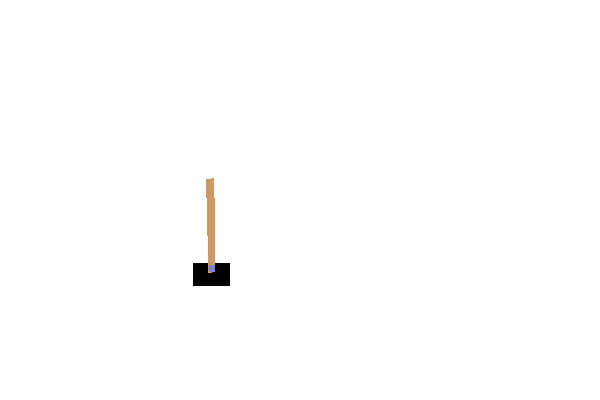
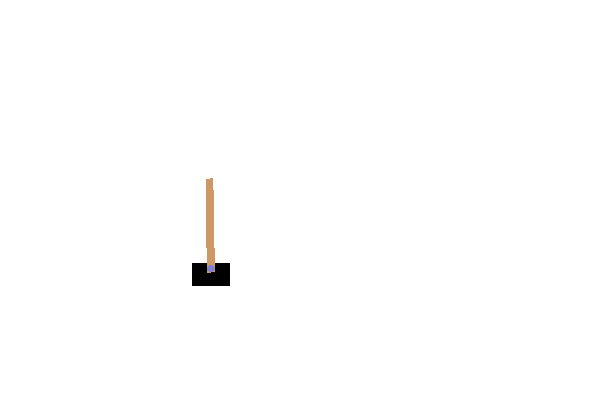
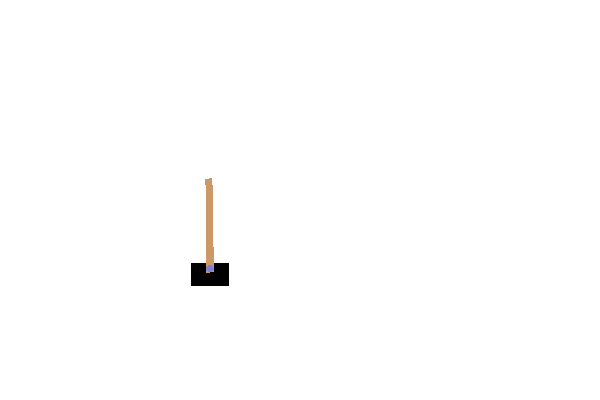
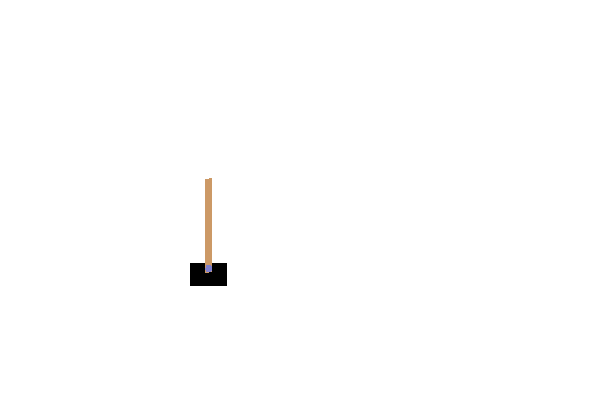
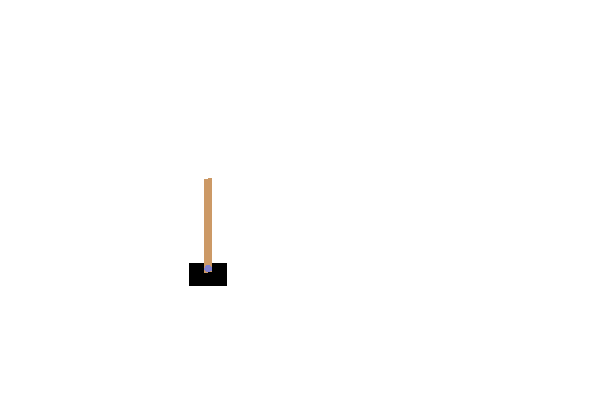
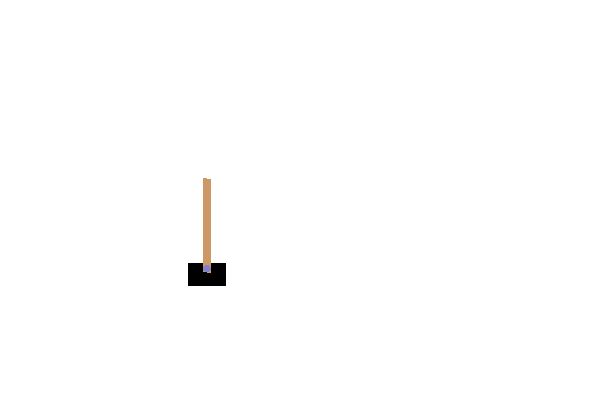
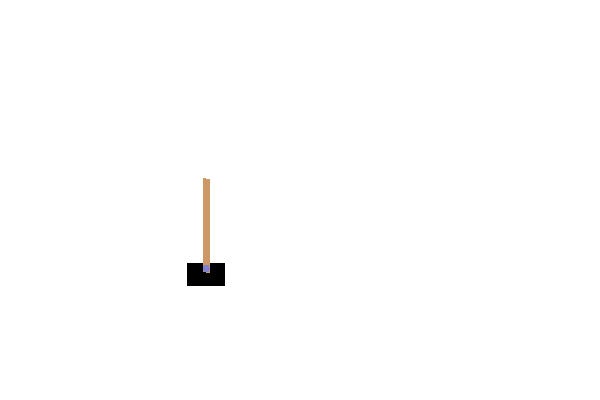
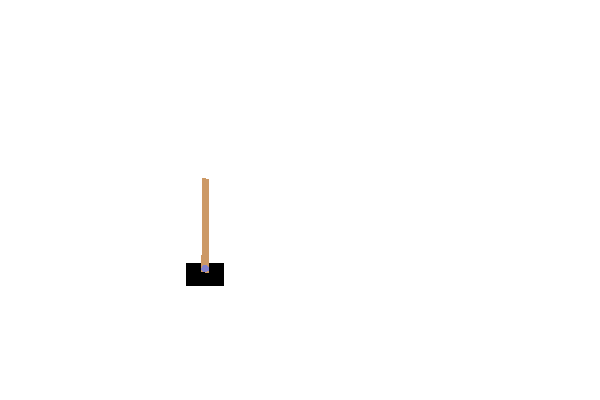
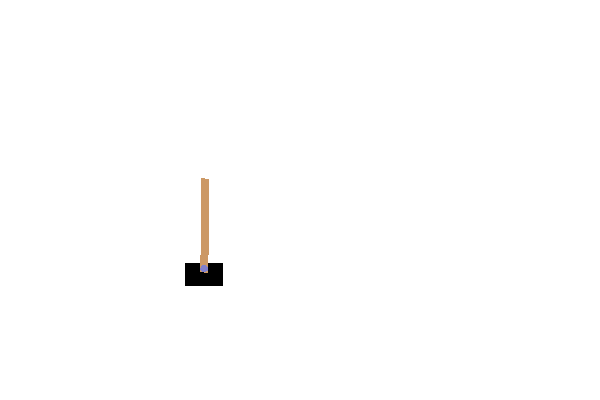
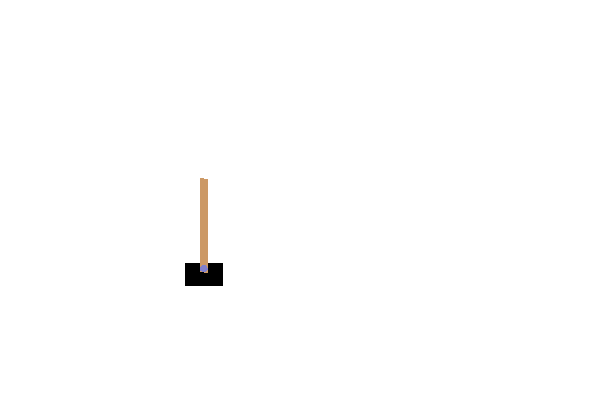
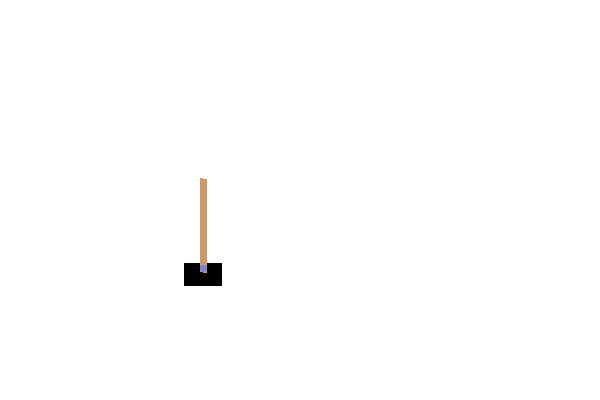
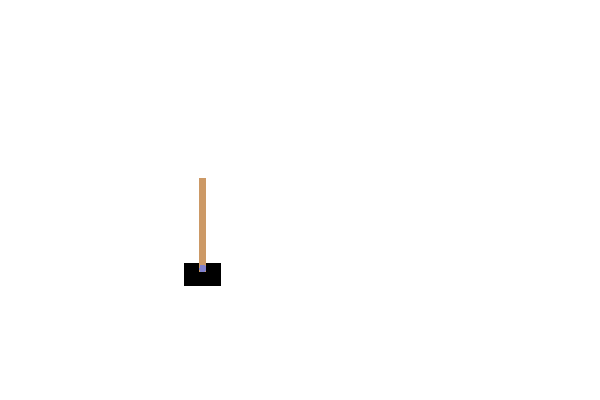
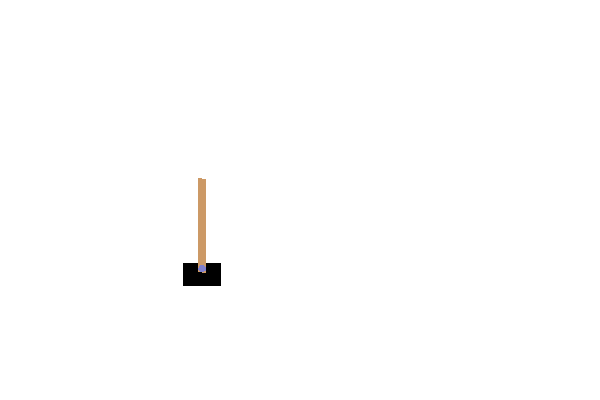
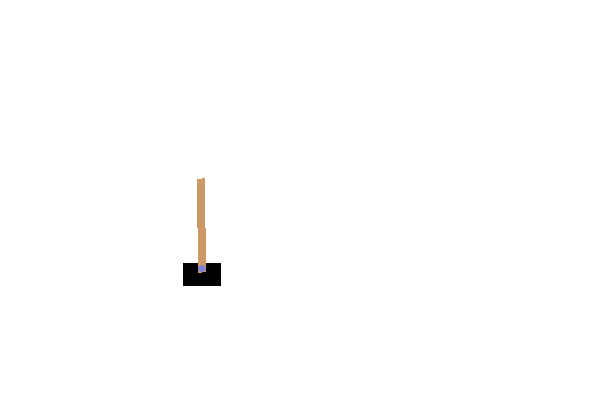
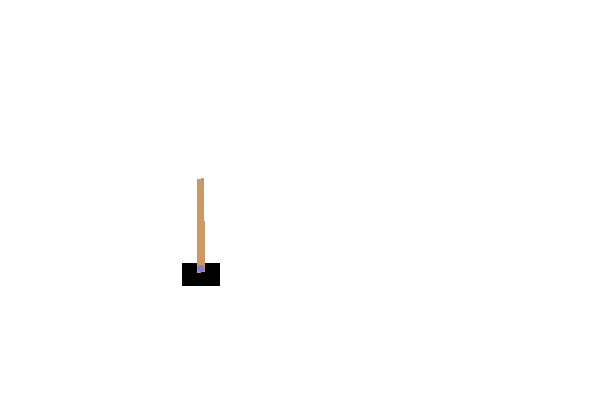
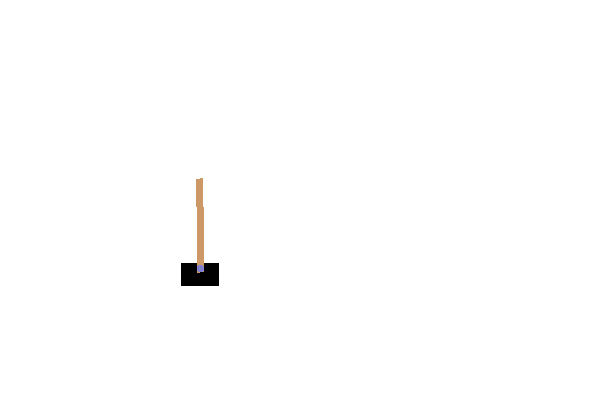
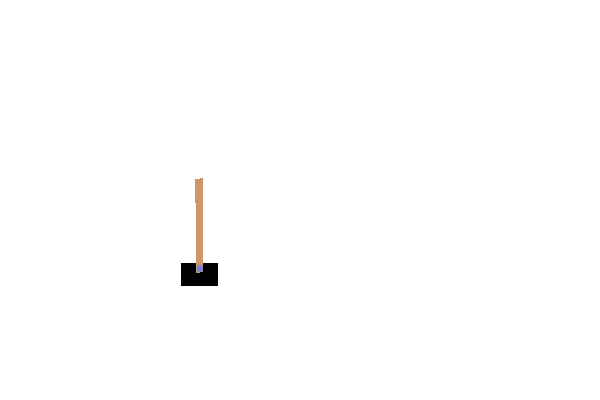
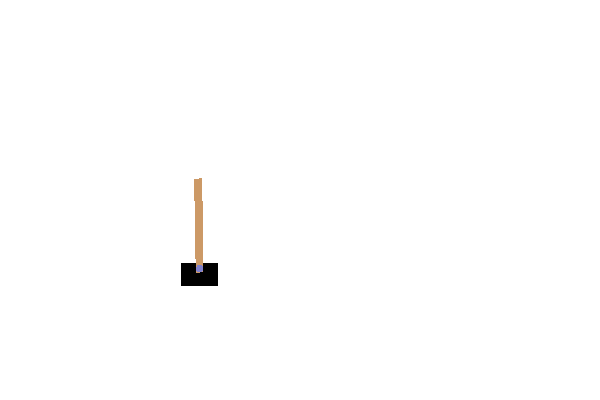
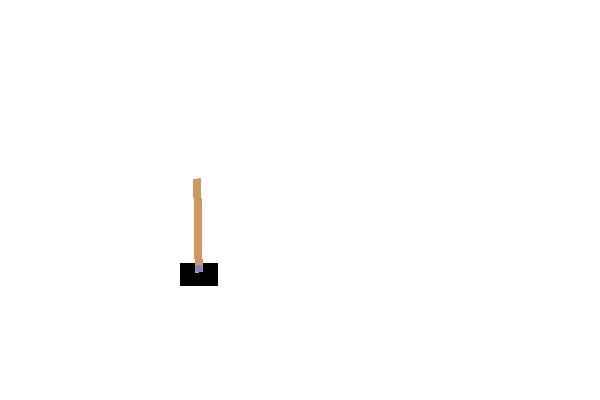
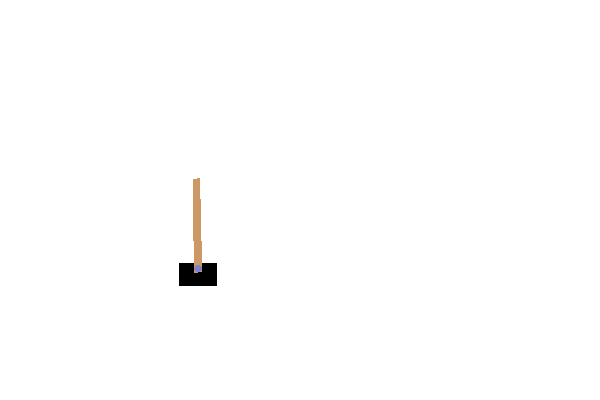
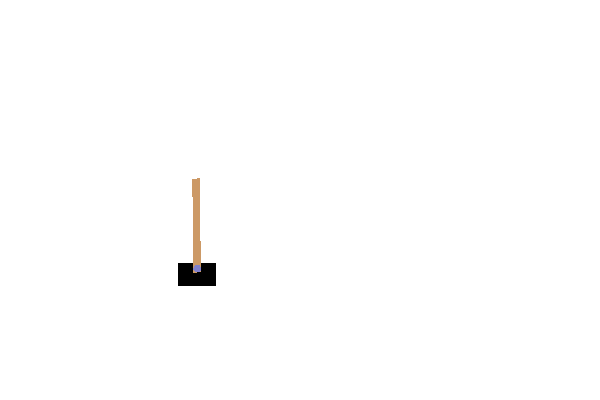
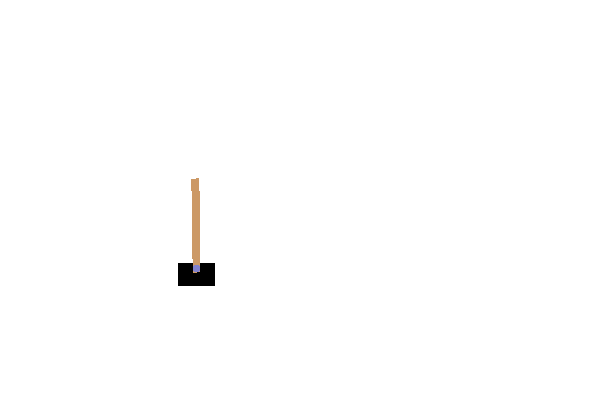
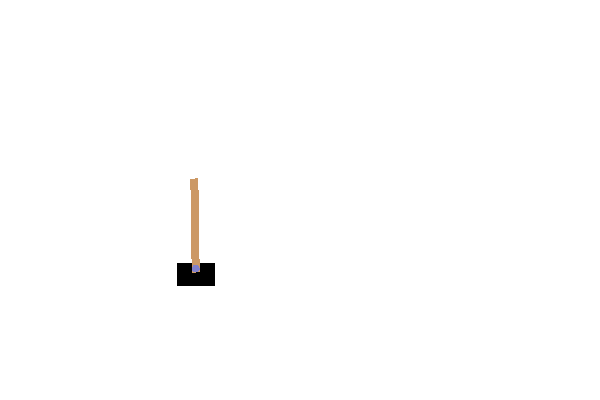
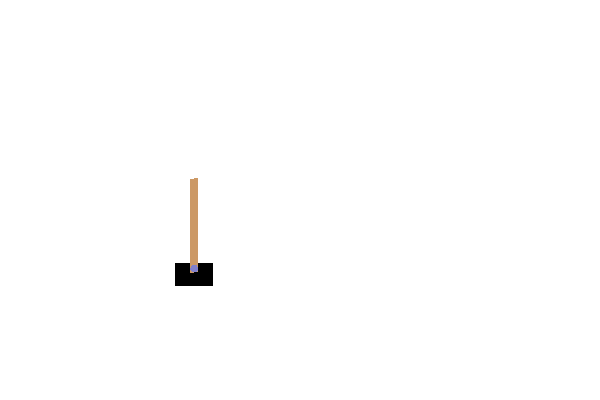
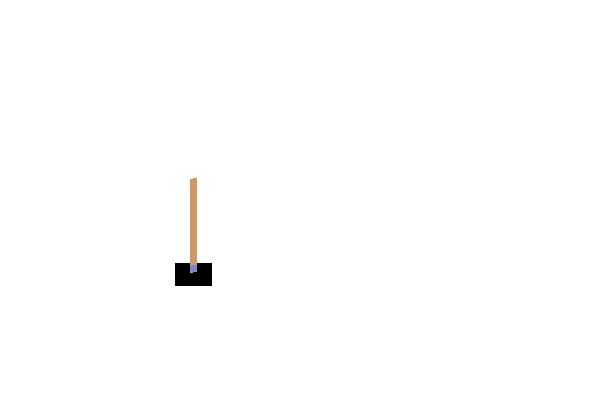
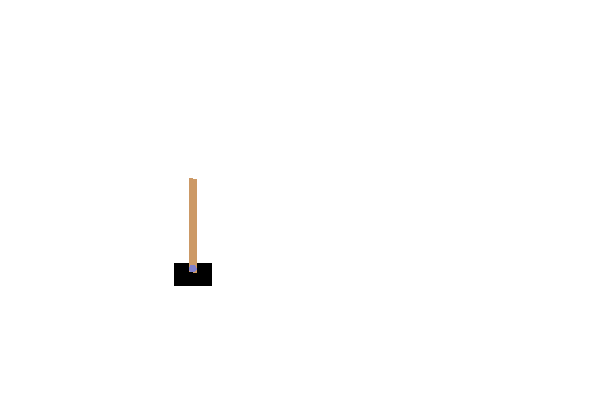
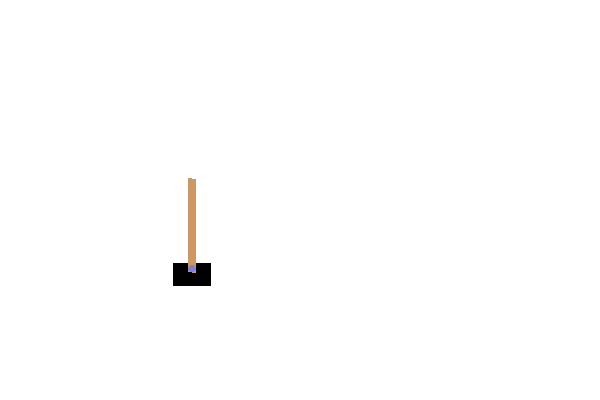
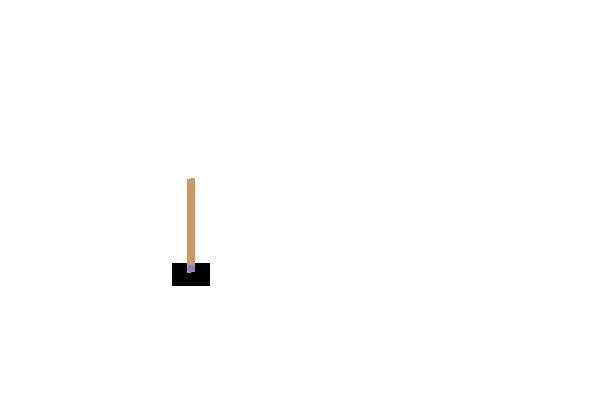
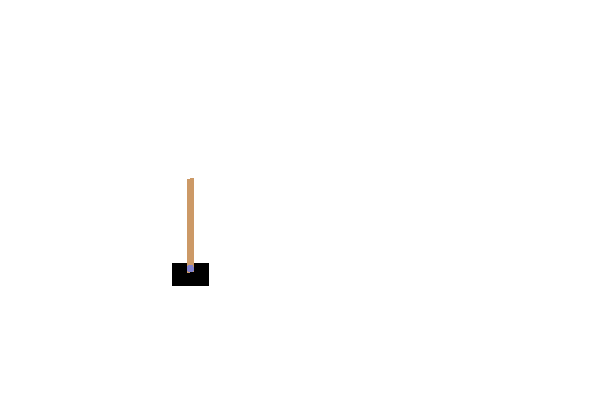
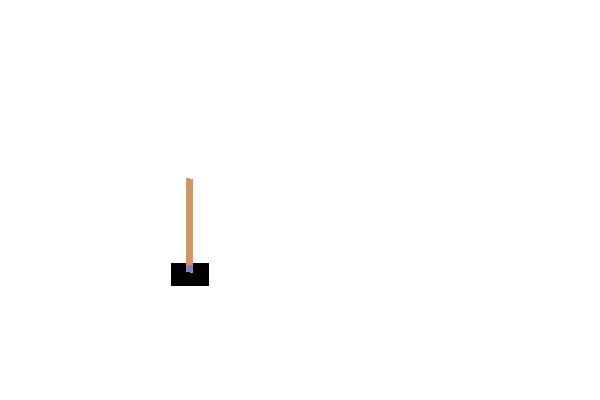
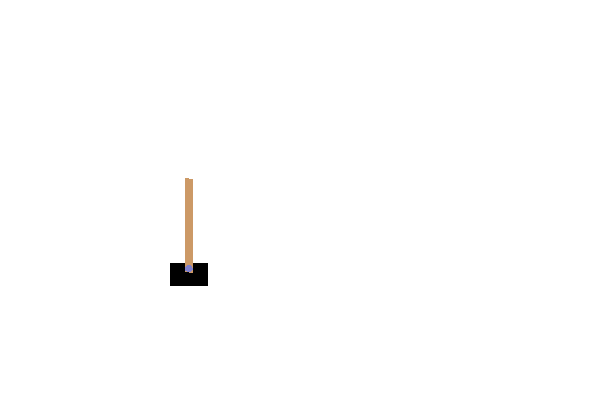
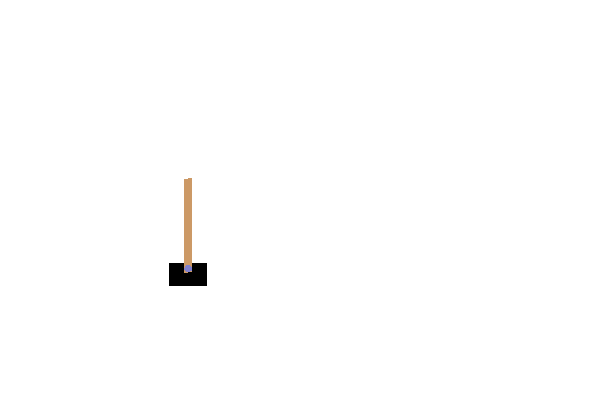
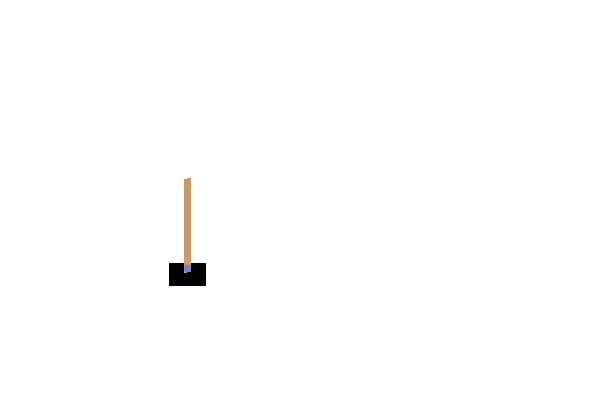
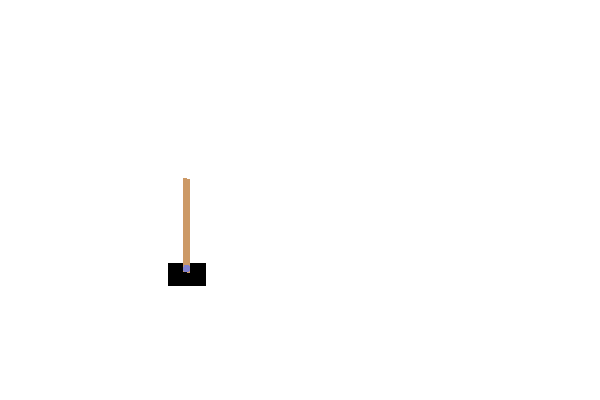
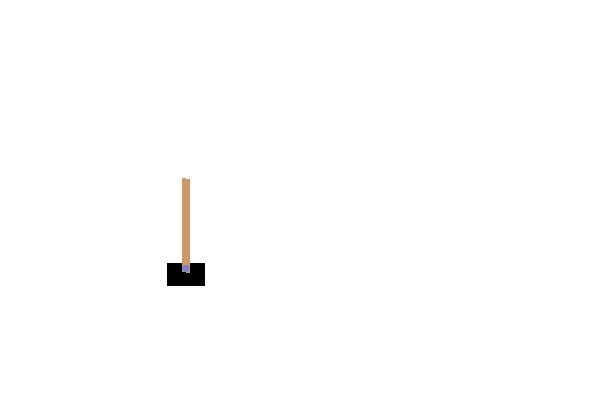
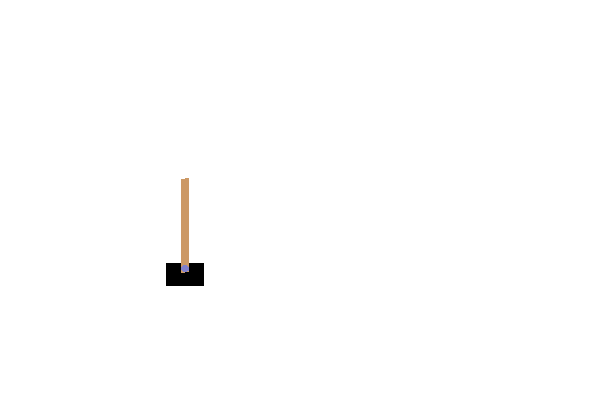
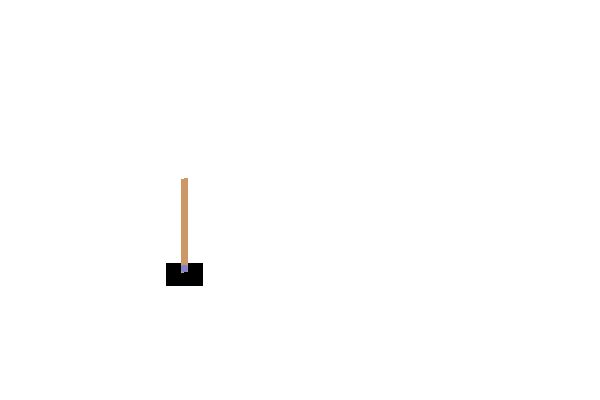
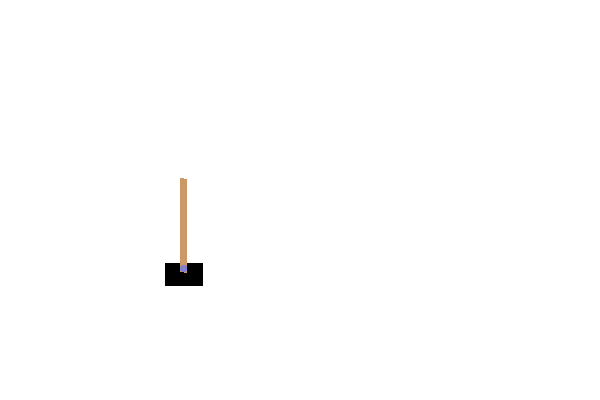
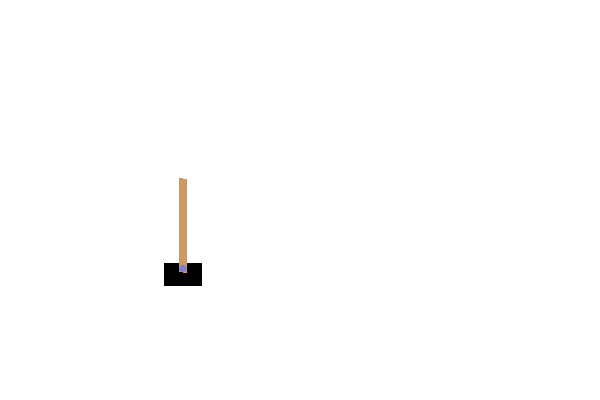
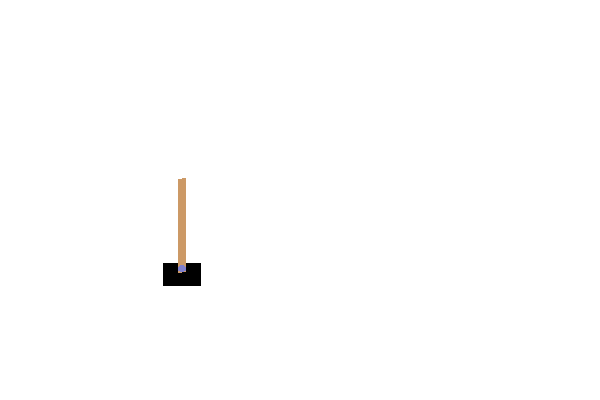
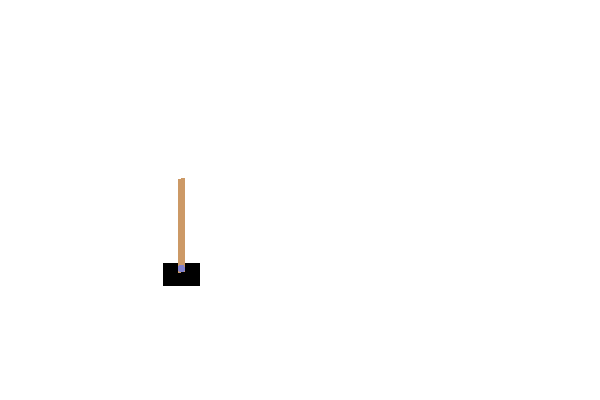
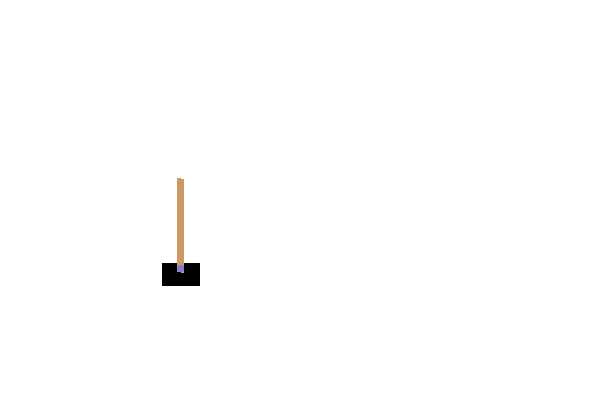
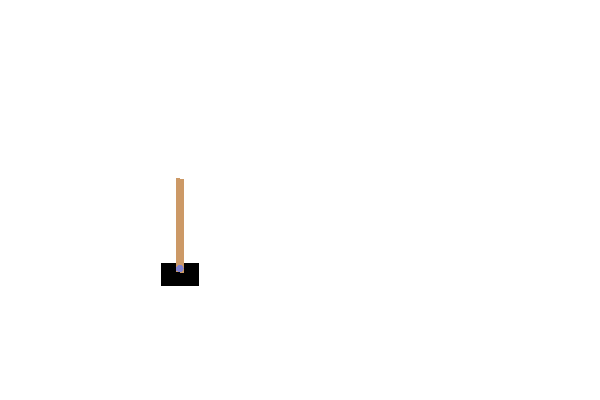
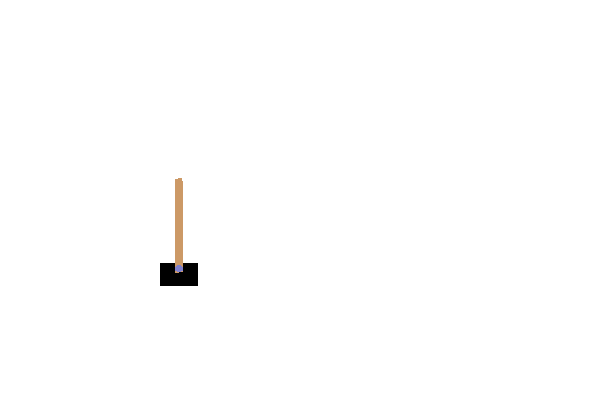
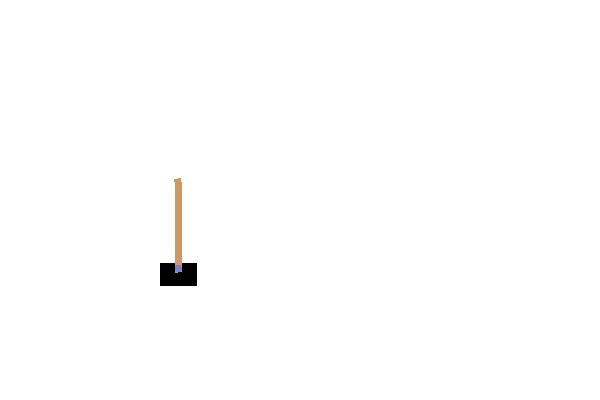
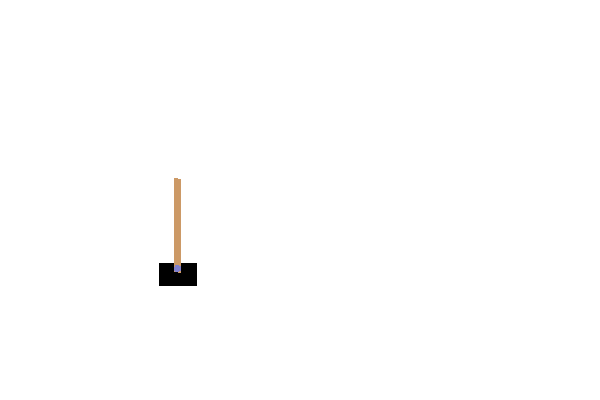
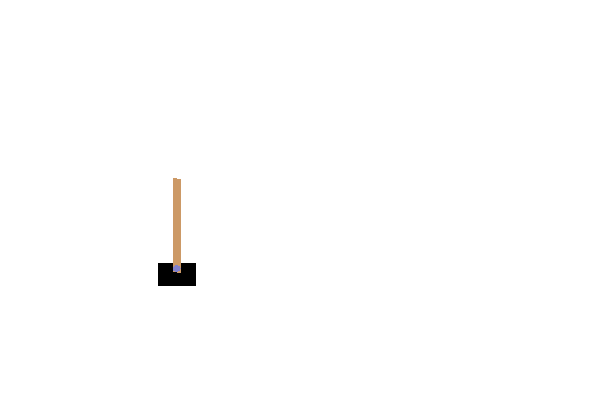
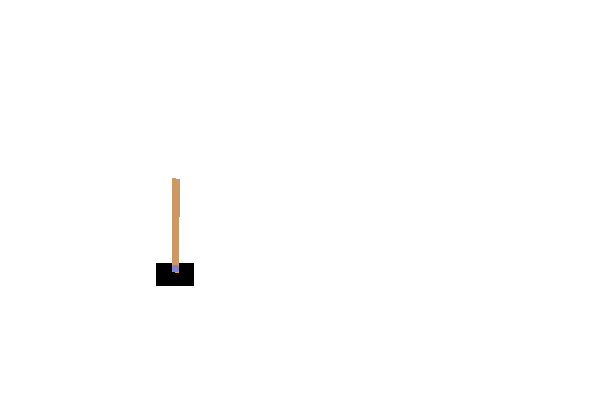
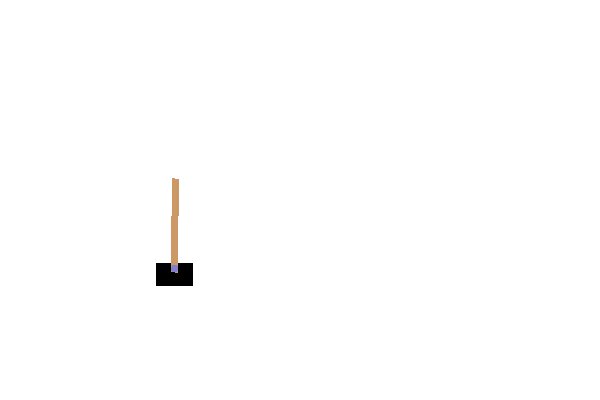
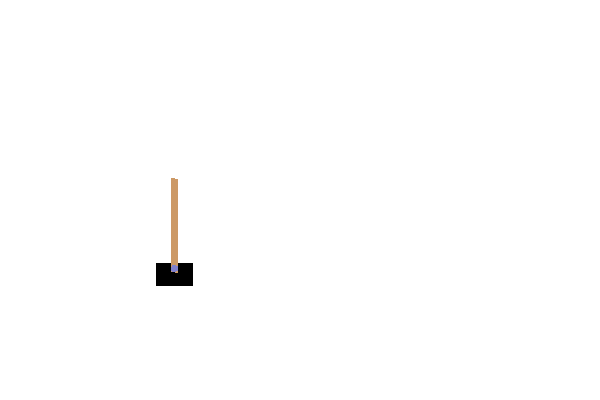
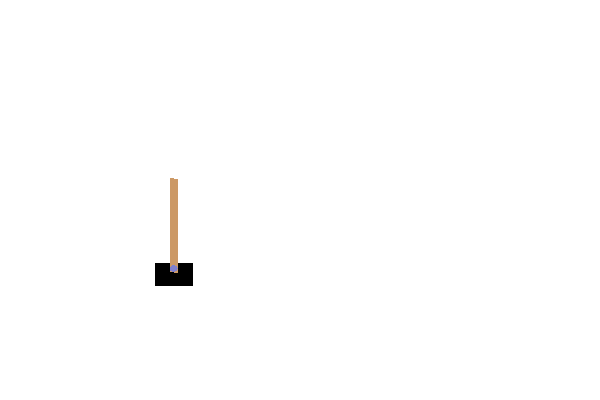
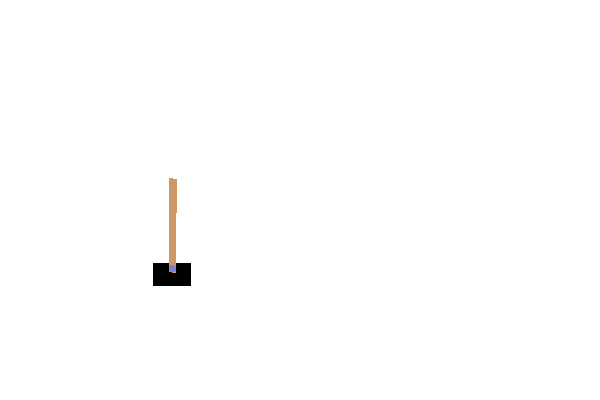
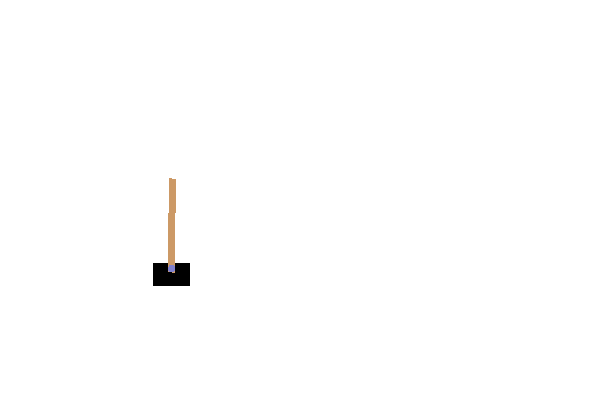

In [5]:
cartpole_env = Environment()
cartpole_env.run()